<a href="https://colab.research.google.com/github/G-S-Basile/M3N_Colab_Fipy/blob/main/EntropyProd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Steps

In [ ]:
!pip install matplotlib==3.7.1

In [ ]:
!apt-get install -y software-properties-common
!add-apt-repository ppa:gmsh/gmsh
!apt-get update
!apt-get install -y gmsh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
ERROR: ppa 'gmsh/gmsh' not found (use --login if private)
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadco

In [ ]:
!apt-get install -y build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
pip install fipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Linear timesteps (Sharp *D* coefficients)

This first script section solves the system of PDEs of our interest under the **assumption of pseudo first order** constants on a suitable .msh mesh. Please note that the mesh is sourced from google drive, thus, if you want to employ this code to test the results, please **use the adequate file path** and a **suitable gmsh mesh**.


---
Furthermore, the following snippets refer to a solving procedure employing linear timesteps, meaning that there is little to no fine understanding of the initial stages of the entropy evolution unless the time step is reduced from 1 s to much smaller values.


Starting the simulation loop...
Step 0, Time: 0.0 s
Step 10, Time: 10.0 s
Step 20, Time: 20.0 s
Step 30, Time: 30.0 s
Step 40, Time: 40.0 s
Step 50, Time: 50.0 s
Step 60, Time: 60.0 s
Step 70, Time: 70.0 s
Step 80, Time: 80.0 s
Step 90, Time: 90.0 s
Step 100, Time: 100.0 s
Step 110, Time: 110.0 s
Step 120, Time: 120.0 s
Step 130, Time: 130.0 s
Step 140, Time: 140.0 s
Step 150, Time: 150.0 s
Step 160, Time: 160.0 s
Step 170, Time: 170.0 s
Step 180, Time: 180.0 s
Step 190, Time: 190.0 s
Step 200, Time: 200.0 s
Step 210, Time: 210.0 s
Step 220, Time: 220.0 s
Step 230, Time: 230.0 s
Step 240, Time: 240.0 s


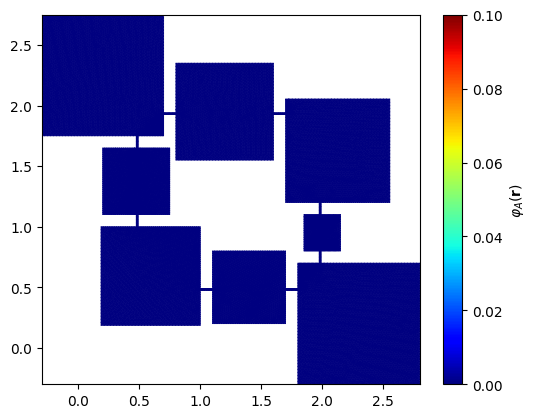

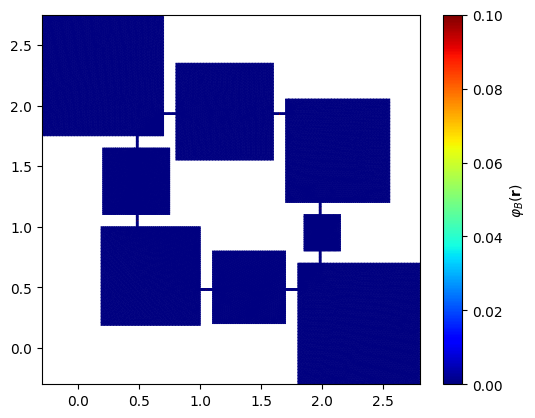

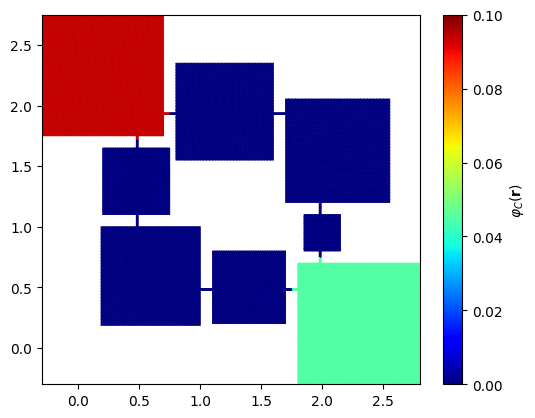

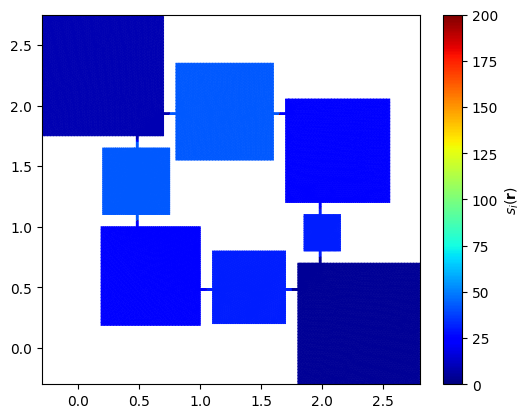

In [ ]:
# @title Linear timesteps - Coupled Mass and Entropy equations
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe STEFANO BASILE
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio



# Load the Gmsh mesh file directly using the file path
# Replace with your actual .msh file path if you want to use this script as a wrapper
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")

# Define the concentration fields for A, B, and S
A = CellVariable(name=r"$\varphi_A(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name=r"$\varphi_B(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name=r"$\varphi_C(\mathbf{r})$", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name=r"$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_values = []
integral_B_outlet2_values = []
integral_C_outlet1_values = []
integral_C_outlet2_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544003745) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= -0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.75) & (fipy_mesh.cellCenters[1] <= 2.75)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.8) & \
          (fipy_mesh.cellCenters[1] >= -0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=0.1
Inlet2=0.1

# Set the A values in the initial regions
A.setValue(Inlet1, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can and have to adjust the region based on the actual membrane geometry)

membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A 1.9 {\mu m^2}{s^-1}
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1           #s^-1
k2 = 0.000001   #s^-1
k_on = 0.1      #s^-1
k_off=1e-6      #s^-1

# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_inlets)  # Block B from diffusing through any membrane
D_C.setValue(0.0, where=membrane_region_outlet)

T = 300
R = 8.314462618
# Define the diffusion-reaction equations with directional diffusion and implicit source terms
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B +source_term4*C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
eq = eq_A & eq_B & eq_C
grad_A = A.grad
grad_B = B.grad
grad_C = C.grad
# Compute the magnitude squared of the gradient
grad_A_squared = numerix.dot(grad_A, grad_A)
grad_B_squared = numerix.dot(grad_B, grad_B)
grad_C_squared = numerix.dot(grad_C, grad_C)
# eq_S = TransientTerm(var=S) == (1/T)*(1 + c*A/B)*D_A*(grad_A_squared) + R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
# eq_S = TransientTerm(var=S) == (1/T)*((1 + c*1/C)*D_A*(grad_A_squared) +  (1+c2*(1/C))*D_B*(grad_B_squared))+ R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
eq_S = TransientTerm(var=S) == R*(1/T)*((1/A)*D_A*(grad_A_squared) +  (1/B)*D_B*(grad_B_squared) + (1/C)*D_C*(grad_C_squared))+ R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))

# Set up the viewers to visualize the concentrations of A and B
viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0e-1)
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1.0e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=2e2)

# Time-stepping parameters
time_step = 1.0  # s
steps = 250  # 100*0.1 s = Number of steps to run the simulation

# Directory to save the frames
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# Logging simulation progress
print("Starting the simulation loop...")

# Lists to store the integrals of B over outlet1 and outlet2 at each time step
integral_C_outlet1_values = []
integral_C_outlet2_values = []
# List to store the integral of S at each time step
integral_S_values = []
# List to store the time derivative of the integral of S
derivative_S_values = []

# Solve the equations iteratively
for step in range(steps):
    eq.solve(dt=time_step)  # Solve for all vars
    grad_A = A.grad
    grad_B = B.grad
    grad_C = C.grad
    # Compute the magnitude squared of the gradient
    grad_A_squared = numerix.dot(grad_A, grad_A)
    grad_B_squared = numerix.dot(grad_B, grad_B)
    grad_C_squared = numerix.dot(grad_C, grad_C)
    eq_S.solve(var=S, dt=time_step)  # Solve for S
    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}, Time: {step * time_step} s")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_values.append(integral_C_outlet1)
    integral_C_outlet2_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_values.append(integral_S)  # Store the integral value

    # Plot results
    #viewer_A.plot()
    #viewer_B.plot()
    #viewer_C.plot()
    #viewer_S.plot()

    # Save figure for video
    #plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# Create video from saved frames
#with imageio.get_writer('simulation_gradS_nonorm_completeBranch.mp4', fps=48) as video_writer:
#    for step in range(steps):
#        filename = f"{frame_dir}/frame_{step:03d}.png"
#        video_writer.append_data(imageio.imread(filename))

# Clean up by removing saved frames
#for step in range(steps):
#    os.remove(f"{frame_dir}/frame_{step:03d}.png")

viewer_A.plot()
viewer_B.plot()
viewer_C.plot()
viewer_S.plot()


Starting the simulation loop...
Step 0, Time: 0.0 s, Injection value: 0.0
Step 10, Time: 10.0 s, Injection value: 0.00212
Step 20, Time: 20.0 s, Injection value: 0.00424
Step 30, Time: 30.0 s, Injection value: 0.0
Step 40, Time: 40.0 s, Injection value: 0.0
Step 50, Time: 50.0 s, Injection value: 0.0
Step 60, Time: 60.0 s, Injection value: 0.0
Step 70, Time: 70.0 s, Injection value: 0.0
Step 80, Time: 80.0 s, Injection value: 0.0
Step 90, Time: 90.0 s, Injection value: 0.0
Step 100, Time: 100.0 s, Injection value: 0.0
Step 110, Time: 110.0 s, Injection value: 0.0
Step 120, Time: 120.0 s, Injection value: 0.0
Step 130, Time: 130.0 s, Injection value: 0.0
Step 140, Time: 140.0 s, Injection value: 0.0
Step 150, Time: 150.0 s, Injection value: 0.0
Step 160, Time: 160.0 s, Injection value: 0.0
Step 170, Time: 170.0 s, Injection value: 0.0
Step 180, Time: 180.0 s, Injection value: 0.0
Step 190, Time: 190.0 s, Injection value: 0.0
Step 200, Time: 200.0 s, Injection value: 0.0
Step 210, Time: 

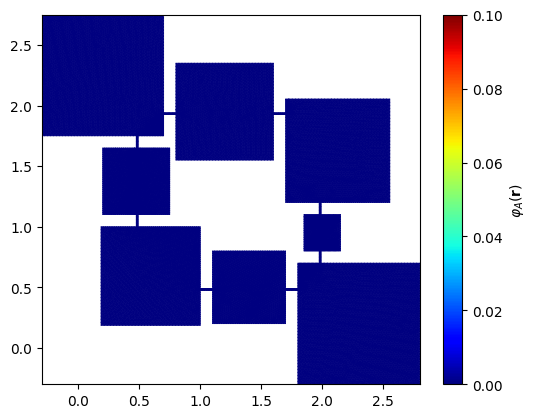

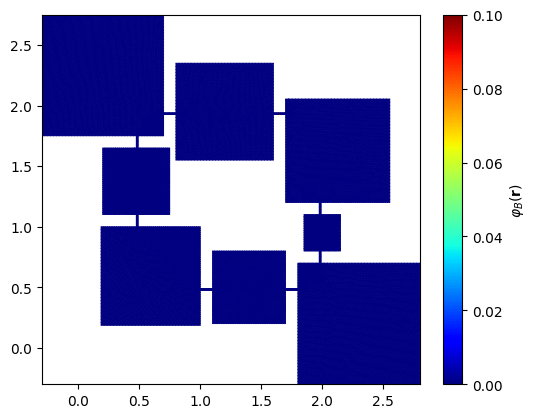

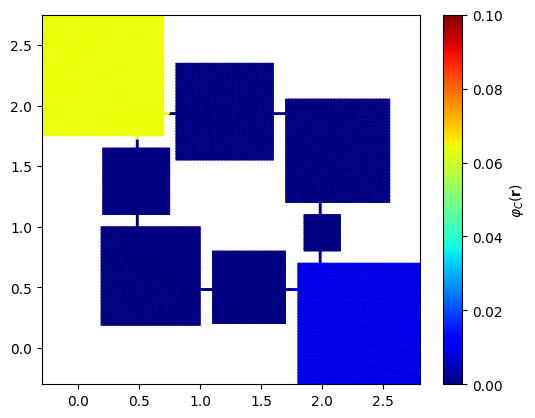

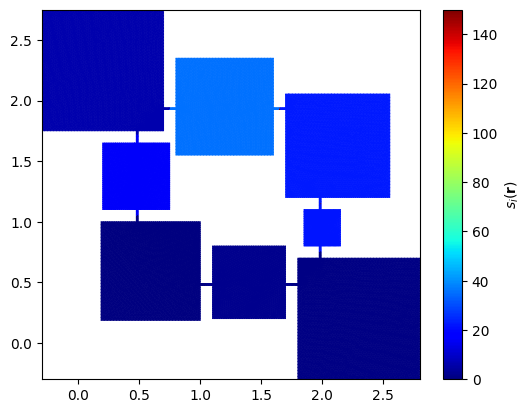

In [ ]:
# @title Linear timesteps - Injection (with localized inlet injection)
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe STEFANO BASILE
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"

from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import numpy as np
from fipy.tools import numerix
import imageio

# Load the Gmsh mesh file directly using the file path
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")

# Define the concentration fields for A, B, C, and S
A = CellVariable(name=r"$\varphi_A(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)
B = CellVariable(name=r"$\varphi_B(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)
C = CellVariable(name=r"$\varphi_C(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)
S = CellVariable(name=r"$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store integrals (for analysis later)
integral_B_outlet1_inject_values = []
integral_B_outlet2_inject_values = []
integral_C_outlet1_inject_values = []
integral_C_outlet2_inject_values = []
integral_S_inject_values = []

# Define the regions where A is preset initially (inlets)
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <= 1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544003745) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Define a smaller injection region within Inlet 1 (adjust the bounds as desired)
# Here, we inject only in cells with x and y coordinates in [0.1860589702, 0.5]
injection_region = initial_region1 & \
    ((fipy_mesh.cellCenters[0] >= 0.495) & (fipy_mesh.cellCenters[0] <= 0.5)) & \
    ((fipy_mesh.cellCenters[1] >= 0.495) & (fipy_mesh.cellCenters[1] <= 0.5))

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= -0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.75) & (fipy_mesh.cellCenters[1] <= 2.75)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.8) & \
          (fipy_mesh.cellCenters[1] >= -0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

# Set baseline initial values in the inlets
Inlet1 = 0.1
Inlet2 = 0.1
A.setValue(1e-10, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane regions (adjust based on your actual geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                   (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4
outside_membrane_region = ~membrane_region

# Diffusion coefficients
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)
D_C = CellVariable(mesh=fipy_mesh, value=0.80)

# Reaction rate constants
k = 1           # s^-1
k2 = 1e-6       # s^-1
k_on = 0.1      # s^-1
k_off = 1e-6    # s^-1

# Create source term variables for the reaction parts (as before)
source_term  = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)
reaction_zone = ~initial_region

source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# Additional membrane regions (if needed for flux conditions)
membrane_region9  = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & \
                    (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                    (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & \
                    (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & \
                    (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)
D_B.setValue(0.0, where=membrane_region_inlets)
D_C.setValue(0.0, where=membrane_region_outlet)

T = 300
R = 8.314462618

# ------------------------------
# Add a time-dependent injection source for A
# ------------------------------
# Create a new source variable for injection
injection_A = CellVariable(mesh=fipy_mesh, value=0.0)

# Modify eq_A to include the injection source:
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B + injection_A
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B + source_term4 * C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
eq = eq_A & eq_B & eq_C

# (The equation for S remains as previously defined)
eq_S = TransientTerm(var=S) == R*(1/T)*((1/A)*D_A*(numerix.dot(A.grad, A.grad)) +
                                         (1/B)*D_B*(numerix.dot(B.grad, B.grad)) +
                                         (1/C)*D_C*(numerix.dot(C.grad, C.grad))) + \
       R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  \
       R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))

# Set up viewers
viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0e-1)
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1.0e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=1.5e2)

# Time-stepping parameters
time_step = 1.0  # s
steps = 250

# Directory for saving frames (if needed)
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

print("Starting the simulation loop...")

# Define injection parameters:
# In this implementation, the injection coefficient is computed numerically
# you can, however, set it to the analytical value by changing the np.sum() term to the correct number

injection_end_step = 25       # injection active for first 50 timesteps
injection_coefficient = (2*Inlet1*0.6625)/(injection_end_step**2)  # injection rate (concentration units per second)

for step in range(steps):
    # Update the time-dependent injection source for A in the localized injection region
    if step <= injection_end_step:
        current_injection = injection_coefficient * (step * time_step)
    else:
        current_injection = 0.0
    # Set injection value only in the defined injection_region
    injection_A.setValue(current_injection, where=injection_region)

    # Solve the coupled equations:
    eq.solve(dt=time_step)
    eq_S.solve(var=S, dt=time_step)

    # (Optional) Compute integrals over outlets and for S:
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)

    integral_C_outlet1_inject_values.append(integral_C_outlet1)
    integral_C_outlet2_inject_values.append(integral_C_outlet2)
    integral_S_inject_values.append(integral_S)

    if step % 10 == 0:
        print(f"Step {step}, Time: {step * time_step} s, Injection value: {current_injection}")

# Final visualization:
viewer_A.plot()
viewer_B.plot()
viewer_C.plot()
viewer_S.plot()


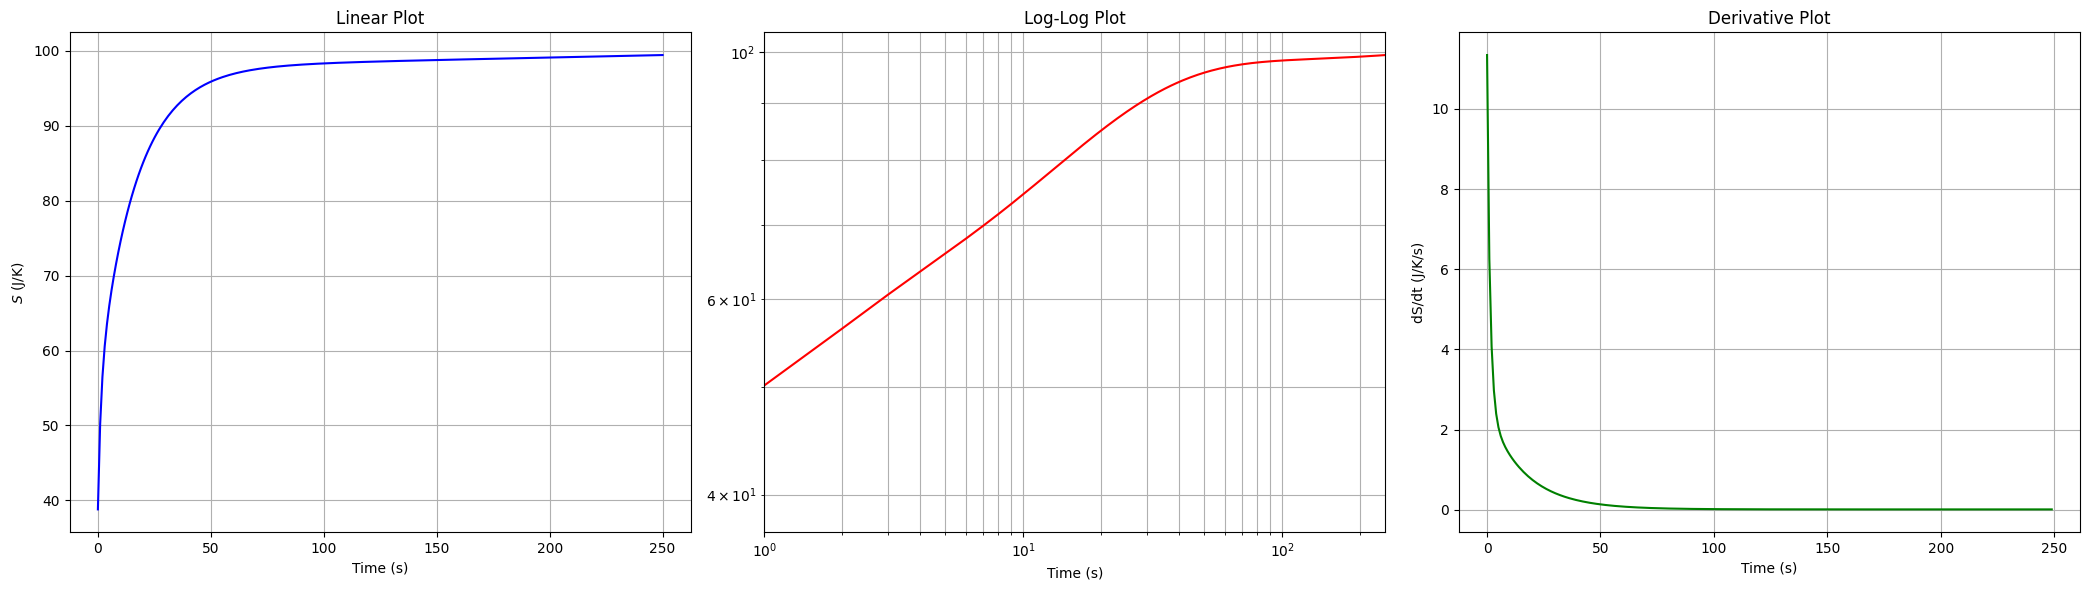

In [ ]:
# @title Plot the results - Linear
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'steps', 'time_step', and 'integral_S_values' are defined
time_values = np.linspace(0, steps * time_step, steps)
integral_S_values = np.array(integral_S_values)  # ensure it's a numpy array

# Create a figure with 3 subplots arranged in a row
fig, axs = plt.subplots(1, 3, figsize=(21, 6))  # Adjust figsize as needed

# 1. Linear-Linear Plot
axs[0].plot(time_values, integral_S_values, color='blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('$S$ (J/K)')
axs[0].set_title('Linear Plot')
axs[0].grid(True)

# 2. Log-Log Plot (both axes logarithmic)
axs[1].loglog(time_values, integral_S_values, color='red')
axs[1].set_xlabel('Time (s)')
axs[1].set_xlim(1, 250)
axs[1].set_title('Log-Log Plot')
axs[1].grid(True, which='both')

# 3. Derivative Plot
# Compute the numerical derivative of S with respect to time
derivative_values = np.diff(integral_S_values) / np.diff(time_values)
# Plot against the midpoints or simply time_values[:-1]
axs[2].plot(time_values[:-1], derivative_values, color='green')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('dS/dt (J/K/s)')
axs[2].set_title('Derivative Plot')
axs[2].grid(True)

# Adjust layout, save, and show the figure
plt.tight_layout()
plt.savefig("combined_plots.png", dpi=300)
plt.show()



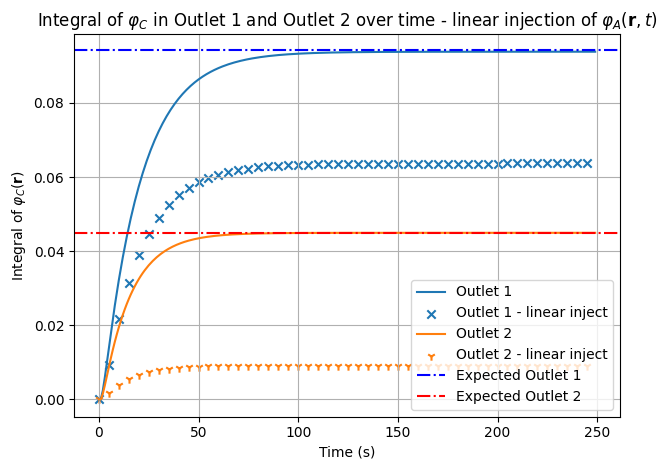

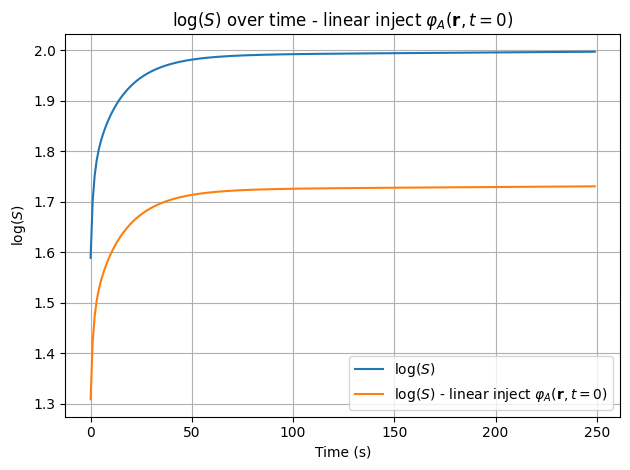

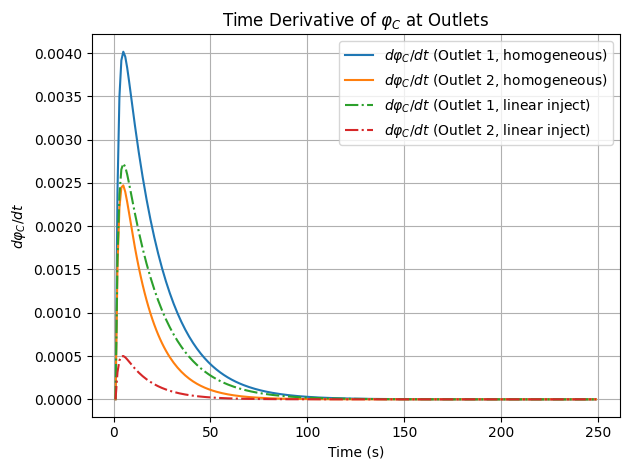

$L^2$ distance between the derivatives (Outlet 1): 0.004736539844682679
$L^2$ distance between the derivatives (Outlet 2): 0.0023142532733797933
Discrete Fréchet distance between concentration derivatives (Outlet 1): 0.0012912992669702646
Discrete Fréchet distance between log(entropy) integrals: 45.65429991695066
Discrete Fréchet distance between φ_C integrals (Outlet 1): 0.030171558937648488


In [ ]:

# @title Plot the results - Homogeneous vs Inject
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Define the time array
# -------------------------------
# Assuming that "steps" and "time_step" are already defined
time = np.arange(0, steps * time_step, time_step)

# --------------------------------------------------
# Plot the integral of φ_C over Outlet 1 and Outlet 2 over time
# --------------------------------------------------
plt.figure()
plt.plot(time, integral_C_outlet1_values, label='Outlet 1')
# Use slicing [::5] to select every 5th point for the scatter plot
plt.scatter(time[::5], integral_C_outlet1_inject_values[::5], marker='x', label='Outlet 1 - linear inject')
plt.plot(time, integral_C_outlet2_values, label='Outlet 2')
plt.scatter(time[::5], integral_C_outlet2_inject_values[::5], marker='1', label='Outlet 2 - linear inject')

# Horizontal lines for the expected values
plt.axhline(y=0.9425e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')

plt.xlabel('Time (s)')
plt.ylabel(r'Integral of $\varphi_C(\mathbf{r})$')
plt.title(r'Integral of $\varphi_C$ in Outlet 1 and Outlet 2 over time - linear injection of $\varphi_A(\mathbf{r},t)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("C_over_time_linear_inject.png", dpi=300)
plt.show()

# --------------------------------------------------
# Plot the integral of S (on a logarithmic scale) over time
# --------------------------------------------------
plt.figure()
plt.plot(time, np.log10(integral_S_values), label='log($S$)')
plt.plot(time, np.log10(integral_S_inject_values), label=r'log($S$) - linear inject $\varphi_A(\mathbf{r}, t=0)$')
plt.xlabel('Time (s)')
plt.ylabel('log($S$)')
plt.title(r'log($S$) over time - linear inject $\varphi_A(\mathbf{r}, t=0)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("IntegralLog_inject-S.png", dpi=300)
plt.show()

# --------------------------------------------------
# Compute and plot the time derivative of the concentration integrals (with comparison)
# --------------------------------------------------
# Compute the derivative using finite differences (np.diff)
# NOTE: np.diff returns an array with one element less than "time"

# Derivatives for the homogeneous data
dC1_dt = np.diff(integral_C_outlet1_values) / time_step
dC2_dt = np.diff(integral_C_outlet2_values) / time_step

# Derivatives for the inhomogeneous data
dC1_inject_dt = np.diff(integral_C_outlet1_inject_values) / time_step
dC2_inject_dt = np.diff(integral_C_outlet2_inject_values) / time_step

plt.figure()
# Plot homogeneous data with markers
plt.plot(time[1:], dC1_dt, label=r"$d\varphi_C/dt$ (Outlet 1, homogeneous)")
plt.plot(time[1:], dC2_dt, label=r"$d\varphi_C/dt$ (Outlet 2, homogeneous)")
# Plot inhomogeneous data with markers
plt.plot(time[1:], dC1_inject_dt, linestyle="dashdot", label=r"$d\varphi_C/dt$ (Outlet 1, linear inject)")
plt.plot(time[1:], dC2_inject_dt, linestyle="dashdot", label=r"$d\varphi_C/dt$ (Outlet 2, linear inject)")

plt.xlabel('Time (s)')
plt.ylabel(r"$d\varphi_C/dt$")
plt.title(r"Time Derivative of $\varphi_C$ at Outlets")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Concentration_Derivatives_linear_inject_comparison.png", dpi=300)
plt.show()

# Assuming dC1_dt and dC1_inhom_dt are already computed and time_step is defined:
L2_distance_1 = np.sqrt(np.sum((dC1_dt - dC1_inject_dt)**2) * time_step)
L2_distance_2 = np.sqrt(np.sum((dC2_dt - dC1_inject_dt)**2) * time_step)

print("$L^2$ distance between the derivatives (Outlet 1):", L2_distance_1)
print("$L^2$ distance between the derivatives (Outlet 2):", L2_distance_2)

# --- Define discrete Fréchet distance function ---
def discrete_frechet_distance(P, Q):
    """
    Compute the discrete Fréchet distance between two 1D arrays P and Q.
    Here, P and Q are assumed to be arrays of scalar values (sampled over time).

    The algorithm uses dynamic programming.
    """
    n = len(P)
    m = len(Q)
    ca = np.full((n, m), -1.0)

    def c(i, j):
        if ca[i, j] > -1:
            return ca[i, j]
        d = abs(P[i] - Q[j])
        if i == 0 and j == 0:
            ca[i, j] = d
        elif i > 0 and j == 0:
            ca[i, j] = max(c(i-1, 0), d)
        elif i == 0 and j > 0:
            ca[i, j] = max(c(0, j-1), d)
        elif i > 0 and j > 0:
            ca[i, j] = max(min(c(i-1, j), c(i-1, j-1), c(i, j-1)), d)
        else:
            ca[i, j] = float('inf')
        return ca[i, j]

    return c(n-1, m-1)

# --- Example: Using your simulation data arrays ---
# (Assuming that the following arrays are already computed over time with uniform time spacing "time_step")
#   - integral_C_outlet1_values: homogeneous case integral of φ_C at Outlet 1
#   - integral_C_outlet1_inject_values: injection case integral of φ_C at Outlet 1
#   - integral_S_values and integral_S_inject_values: corresponding integrals of S
#   - dC1_dt: finite-difference derivative (homogeneous) of integral_C_outlet1_values
#   - dC1_inhom_dt: finite-difference derivative (injection) of integral_C_outlet1_inject_values

# --- Compute discrete Fréchet distances for each pair ---
frechet_deriv = discrete_frechet_distance(dC1_dt, dC1_inject_dt)
frechet_entropy = discrete_frechet_distance(integral_S_values, integral_S_inject_values)
frechet_integralC = discrete_frechet_distance(integral_C_outlet1_values, integral_C_outlet1_inject_values)

print("Discrete Fréchet distance between concentration derivatives (Outlet 1):", frechet_deriv)
print("Discrete Fréchet distance between log(entropy) integrals:", frechet_entropy)
print("Discrete Fréchet distance between φ_C integrals (Outlet 1):", frechet_integralC)
# # --------------------------------------------------
# # Compute and plot the heatmap of ln(S) over the mesh at the final time step
# # --------------------------------------------------
# # Compute ln(S) and replace non-positive values with NaN to avoid errors
# ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)

# # Extract the X and Y coordinates of the mesh cell centers
# x = np.array(fipy_mesh.cellCenters[0])
# y = np.array(fipy_mesh.cellCenters[1])

# plt.figure(figsize=(8, 6))
# plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
# plt.colorbar(label='ln(S)')
# plt.title('Heatmap of ln(S) over the mesh at final time step')
# plt.xlabel('X coordinate')
# plt.ylabel('Y coordinate')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Heatmap_lnS.png", dpi=300)
# plt.show()


Starting simulation...
Step 000: Mean A = 8.371e-02, Simulated Variance = 1.198e-02, Theoretical Variance = 4.921e+02
Step 010: Mean A = 7.799e-02, Simulated Variance = 1.043e-02, Theoretical Variance = 4.584e+02
Step 020: Mean A = 7.836e-02, Simulated Variance = 1.065e-02, Theoretical Variance = 4.606e+02
Step 030: Mean A = 7.851e-02, Simulated Variance = 1.059e-02, Theoretical Variance = 4.615e+02
Step 040: Mean A = 7.816e-02, Simulated Variance = 1.062e-02, Theoretical Variance = 4.594e+02
Step 050: Mean A = 7.664e-02, Simulated Variance = 1.030e-02, Theoretical Variance = 4.505e+02
Step 060: Mean A = 7.884e-02, Simulated Variance = 1.063e-02, Theoretical Variance = 4.634e+02
Step 070: Mean A = 7.699e-02, Simulated Variance = 1.036e-02, Theoretical Variance = 4.526e+02
Step 080: Mean A = 7.850e-02, Simulated Variance = 1.080e-02, Theoretical Variance = 4.615e+02
Step 090: Mean A = 7.927e-02, Simulated Variance = 1.090e-02, Theoretical Variance = 4.660e+02
Step 100: Mean A = 7.642e-0

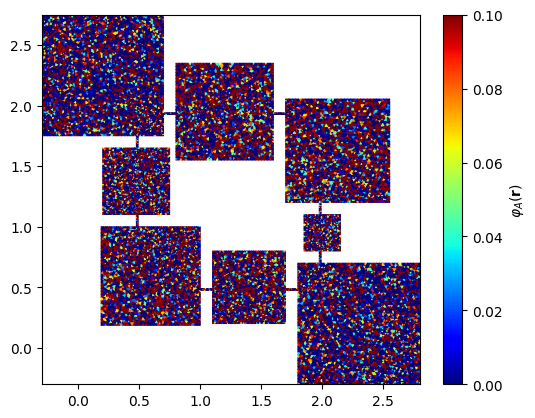

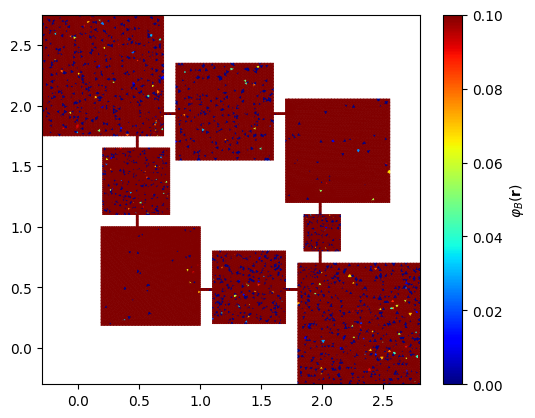

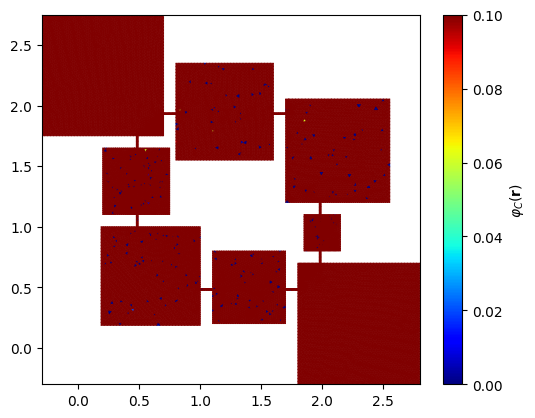

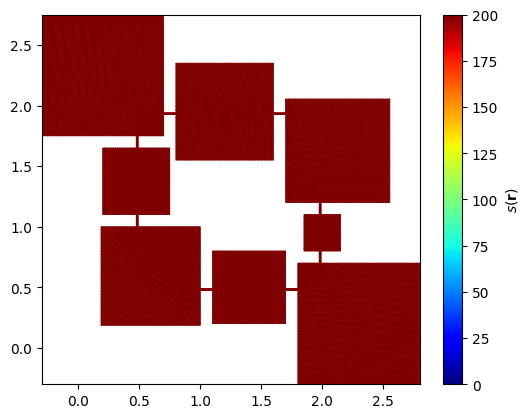

In [ ]:
# @title Linear timesteps - Coupled Mass and Entropy equations with Stochastic Concentrations and Epsilon Fix
# Improved Version with a Physically Realistic Noise Model for Concentration Fluctuations
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024
Modified on 2025-02-06

This code includes a noise model for the concentration fields (A, B, C) that is
consistent with Poisson (shot) noise, i.e., the noise amplitude in each cell scales as
sqrt( A / cellVolume ). This is more realistic at the microscale.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm
from fipy.tools import numerix

# ---------------------------
# Simulation and Solver Setup
# ---------------------------
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"

# Mesh setup: Adjust the file path to your mesh file as needed.
mesh_file_path = "/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh"
mesh = Gmsh2D(mesh_file_path)

# ---------------------------
# Physical Parameters
# ---------------------------
# Diffusion coefficients
D_A_val = 1900.0  # for A
D_B_val = 1300.0  # for B
D_C_val = 0.80    # for C

# Reaction rate constants
k = 1           # s^-1 (A -> B)
k2 = 1e-6       # s^-1 (B -> A)
k_on = 0.1      # s^-1 (B -> C)
k_off = 1e-6    # s^-1 (C -> B)

# Thermodynamic parameters
T = 300  # Temperature (K)
R = 8.314462618  # Gas constant (J/mol/K)

# A small epsilon to avoid division-by-zero
eps = 1e-12

# ---------------------------
# Time-Stepping Parameters
# ---------------------------
time_step = 1.0   # seconds
total_steps = 250 # total number of time steps

# Toggle for noise (set to True to include stochastic fluctuations)
add_noise = True

# ---------------------------
# Mesh Regions Definitions
# ---------------------------
# Convenience: cell centers (x, y)
x, y = mesh.cellCenters

# Regions for initial conditions
initial_region1 = (x >= 0.1860589702) & (x <= 1) & (y >= 0.1860589702) & (y <= 1)
initial_region2 = (x >= 1.7) & (x <= 1.7 + 0.8544003745) & (y >= 1.2) & (y <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlet regions
outlet1 = (x >= -0.3) & (x <= 0.7) & (y >= 1.75) & (y <= 2.75)
outlet2 = (x >= 1.8) & (x <= 2.8) & (y >= -0.3) & (y <= 0.7)
outlet = outlet1 | outlet2

# Membrane regions for blocking diffusion
membrane_region1 = (x >= 1.045) & (x <= 1.055) & (y >= 0.45) & (y <= 0.55)
membrane_region2 = (x >= 0.45) & (x <= 0.55) & (y >= 1.045) & (y <= 1.055)
membrane_region3 = (x >= 1.95) & (x <= 2.05) & (y >= 1.145) & (y <= 1.155)
membrane_region4 = (x >= 1.645) & (x <= 1.655) & (y >= 1.9) & (y <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4
outside_membrane_region = ~membrane_region

# Additional membrane regions for flux conditions at outlets/inlets
membrane_region9  = (x >= 1.745) & (x <= 1.755) & (y >= 0.45) & (y <= 0.55)
membrane_region10 = (x >= 1.95) & (x <= 2.05) & (y >= 0.745) & (y <= 0.755)
membrane_region11 = (x >= 0.475) & (x <= 0.525) & (y >= 1.7) & (y <= 1.725)
membrane_region12 = (x >= 0.745) & (x <= 0.755) & (y >= 1.925) & (y <= 1.975)
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# ---------------------------
# Define CellVariables for Concentrations and Entropy
# ---------------------------
A = CellVariable(name=r"$\varphi_A(\mathbf{r})$", mesh=mesh, value=1e-10)
B = CellVariable(name=r"$\varphi_B(\mathbf{r})$", mesh=mesh, value=1e-10)
C = CellVariable(name=r"$\varphi_C(\mathbf{r})$", mesh=mesh, value=1e-10)
S = CellVariable(name=r"$s(\mathbf{r})$", mesh=mesh, value=1e-10)

# Set initial concentrations for A in the designated regions
A.setValue(0.1, where=initial_region1)
A.setValue(0.1, where=initial_region2)

# ---------------------------
# Define Diffusion Coefficients as CellVariables
# ---------------------------
D_A = CellVariable(mesh=mesh, value=D_A_val)
D_B = CellVariable(mesh=mesh, value=D_B_val)
D_C = CellVariable(mesh=mesh, value=D_C_val)

# Block diffusion in specific membrane regions
D_A.setValue(0.0, where=membrane_region_outlet)  # Block A at outlet membranes
D_B.setValue(0.0, where=membrane_region_inlets)   # Block B at inlet membranes
D_C.setValue(0.0, where=membrane_region_outlet)   # Block C at outlet membranes

# ---------------------------
# Define Source Terms (Reaction Rates)
# ---------------------------
source_term   = CellVariable(mesh=mesh, value=0.0)
source_term2  = CellVariable(mesh=mesh, value=0.0)
source_term3  = CellVariable(mesh=mesh, value=0.0)
source_term4  = CellVariable(mesh=mesh, value=0.0)

# Define reaction zone as the complement of the initial region
reaction_zone = ~initial_region
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# ---------------------------
# Define the Deterministic PDEs for A, B, C
# ---------------------------
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B + source_term4 * C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
reaction_diffusion_eq = eq_A & eq_B & eq_C

# ---------------------------
# Helper Functions
# ---------------------------
def compute_grad_squares():
    """
    Compute the squared magnitudes of the gradients for A, B, and C.
    """
    grad_A = A.grad
    grad_B = B.grad
    grad_C = C.grad
    grad_A_sq = numerix.dot(grad_A, grad_A)
    grad_B_sq = numerix.dot(grad_B, grad_B)
    grad_C_sq = numerix.dot(grad_C, grad_C)
    return grad_A_sq, grad_B_sq, grad_C_sq

def update_entropy(dt):
    """
    Update the entropy field S using the current values of A, B, and C.
    """
    grad_A_sq, grad_B_sq, grad_C_sq = compute_grad_squares()
    eq_S = TransientTerm(var=S) == R / T * (
                (D_A * grad_A_sq) / (A + eps) +
                (D_B * grad_B_sq) / (B + eps) +
                (D_C * grad_C_sq) / (C + eps)
            ) \
            + R * (numerix.log((k * A + eps) / (k2 * B + eps)) * (k * A - k2 * B)) \
            + R * (numerix.log((k_on * B + eps) / (k_off * C + eps)) * (k_on * B - k_off * C))
    eq_S.solve(var=S, dt=dt)

def compute_statistics(var, region_mask=None):
    """
    Compute the weighted mean and variance of a CellVariable over a given region.
    Returns:
        mean_concentration, variance_sim, variance_theo
    """
    if region_mask is None:
        region_mask = np.ones(var.value.shape, dtype=bool)

    volumes = mesh.cellVolumes[region_mask]
    concentrations = var.value[region_mask]
    total_volume = volumes.sum()
    mean_concentration = np.sum(concentrations * volumes) / total_volume
    variance_sim = np.sum(volumes * (concentrations - mean_concentration)**2) / total_volume

    # For the theoretical variance, assume Poisson fluctuations: <(δC)^2> = mean / V_avg.
    n_cells = len(volumes)
    V_avg = total_volume / n_cells
    variance_theo = mean_concentration / V_avg
    return mean_concentration, variance_sim, variance_theo

# ---------------------------
# Set Up Viewers and Logging Variables
# ---------------------------
viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0e-1)
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1.0e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=2e2)

integral_C_outlet1_noise = []
integral_C_outlet2_noise = []
integral_S_noise = []

# ---------------------------
# Optionally Create a Directory for Frame Outputs
# ---------------------------
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# ---------------------------
# Main Simulation Loop
# ---------------------------
print("Starting simulation...")

for step in range(total_steps):
    # Solve the deterministic reaction-diffusion equations for A, B, and C
    reaction_diffusion_eq.solve(dt=time_step)

    # --- Realistic Noise Model Based on Poisson Fluctuations ---
    # For each cell, the noise amplitude is given by:
    #    sqrt( (A_value) / (cellVolume) * dt )
    # This yields a noise with variance A / V (per cell), consistent with Poisson statistics.
    if add_noise:
        A_noise = np.sqrt((np.sum(A.value * fipy_mesh.cellVolumes) / np.sum(fipy_mesh.cellVolumes)) * time_step) * np.random.normal(0, 1, A.value.shape)
        B_noise = np.sqrt((np.sum(B.value * fipy_mesh.cellVolumes) / np.sum(fipy_mesh.cellVolumes)) * time_step) * np.random.normal(0, 1, B.value.shape)
        C_noise = np.sqrt((np.sum(C.value * fipy_mesh.cellVolumes) / np.sum(fipy_mesh.cellVolumes)) * time_step) * np.random.normal(0, 1, C.value.shape)
        A.value += A_noise
        B.value += B_noise
        C.value += C_noise

    # Prevent nonphysical (negative) values by clipping to eps
    A.value = np.clip(A.value, eps, None)
    B.value = np.clip(B.value, eps, None)
    C.value = np.clip(C.value, eps, None)

    # Update the entropy field S based on the current state
    update_entropy(dt=time_step)

    # Log integrals over outlet regions and the global entropy
    integral_C_out1 = numerix.sum(C.value[outlet1] * mesh.cellVolumes[outlet1])
    integral_C_out2 = numerix.sum(C.value[outlet2] * mesh.cellVolumes[outlet2])
    integral_S_global = numerix.sum(S.value * mesh.cellVolumes)

    integral_C_outlet1_noise.append(integral_C_out1)
    integral_C_outlet2_noise.append(integral_C_out2)
    integral_S_noise.append(integral_S_global)

    # Every 10 steps, compute and log the mean and variances for species A
    if step % 10 == 0:
        mean_A, var_A_sim, var_A_theo = compute_statistics(A)
        print(f"Step {step:03d}: Mean A = {mean_A:.3e}, Simulated Variance = {var_A_sim:.3e}, Theoretical Variance = {var_A_theo:.3e}")
        # Optionally, compute for species B and C as well.

    # Optionally, save frames for video output every 10 steps
    # if step % 10 == 0:
    #     plt.figure()
    #     viewer_A.plot()
    #     plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)
    #     plt.close()

# ---------------------------
# Optional: Create a Video from the Saved Frames
# ---------------------------
"""
video_filename = 'simulation_video.mp4'
with imageio.get_writer(video_filename, fps=24) as video_writer:
    for step in range(0, total_steps, 10):
        filename = f"{frame_dir}/frame_{step:03d}.png"
        video_writer.append_data(imageio.imread(filename))
for step in range(0, total_steps, 10):
    os.remove(f"{frame_dir}/frame_{step:03d}.png")
"""

# ---------------------------
# Final Visualization of the Fields
# ---------------------------
viewer_A.plot()
viewer_B.plot()
viewer_C.plot()
viewer_S.plot()

print("Simulation complete.")


Starting simulation...
Step 000: Mean A = 2.909e-02, Simulated Variance = 6.060e-04, Theoretical Variance = 1.710e+02
Step 010: Mean A = 3.436e-05, Simulated Variance = 3.446e-09, Theoretical Variance = 2.020e-01
Step 020: Mean A = 5.881e-06, Simulated Variance = 3.660e-10, Theoretical Variance = 3.457e-02
Step 030: Mean A = 5.532e-07, Simulated Variance = 5.713e-10, Theoretical Variance = 3.252e-03
Step 040: Mean A = 5.145e-05, Simulated Variance = 6.299e-09, Theoretical Variance = 3.024e-01
Step 050: Mean A = 1.805e-05, Simulated Variance = 2.252e-09, Theoretical Variance = 1.061e-01
Step 060: Mean A = 5.910e-06, Simulated Variance = 5.325e-11, Theoretical Variance = 3.474e-02
Step 070: Mean A = 1.894e-06, Simulated Variance = 2.363e-10, Theoretical Variance = 1.114e-02
Step 080: Mean A = 9.733e-05, Simulated Variance = 1.377e-08, Theoretical Variance = 5.721e-01
Step 090: Mean A = 2.871e-06, Simulated Variance = 2.852e-09, Theoretical Variance = 1.688e-02
Step 100: Mean A = 1.700e-0

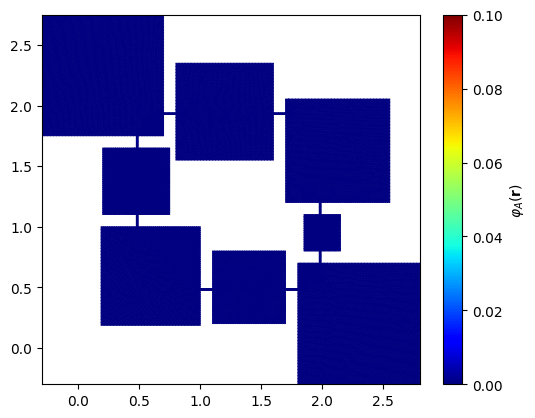

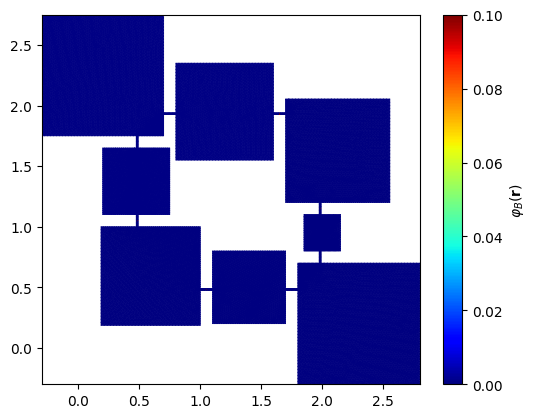

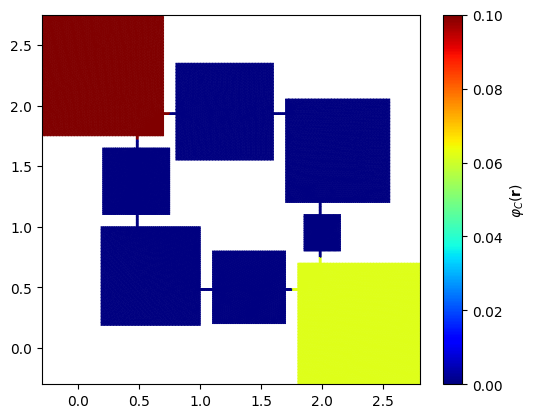

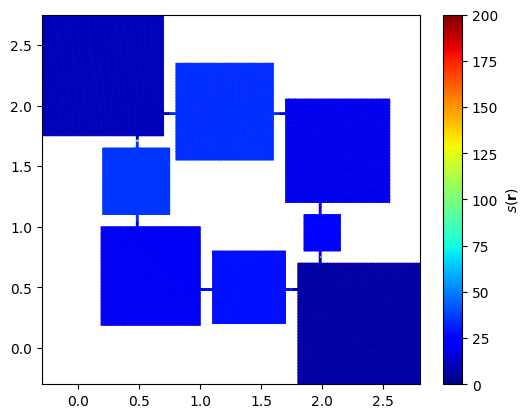

In [ ]:
# @title Linear timesteps - Coupled Mass and Entropy Equations with Stochastic Concentrations and Epsilon Fix
# Improved Version with a Physically Realistic Noise Model Inserted Directly in the Equations
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024
Modified on 2025-02-06

This code includes a noise model for the concentration fields (A, B, C) that is
consistent with Poisson (shot) noise, i.e., the noise amplitude in each cell scales as
sqrt( A / cellVolume ). The noise is inserted directly into the PDEs as additional
source terms.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, GaussianNoiseVariable
from fipy.tools import numerix

# ---------------------------
# Simulation and Solver Setup
# ---------------------------
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"

# Mesh setup: Adjust the file path to your mesh file as needed.
mesh_file_path = "/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh"
mesh = Gmsh2D(mesh_file_path)

# ---------------------------
# Physical Parameters
# ---------------------------
# Diffusion coefficients
D_A_val = 1900.0  # for A
D_B_val = 1300.0  # for B
D_C_val = 0.80    # for C

# Reaction rate constants
k = 1           # s^-1 (A -> B)
k2 = 1e-6       # s^-1 (B -> A)
k_on = 0.1      # s^-1 (B -> C)
k_off = 1e-6    # s^-1 (C -> B)

# Thermodynamic parameters
T = 300  # Temperature (K)
R = 8.314462618  # Gas constant (J/mol/K)

# A small epsilon to avoid division-by-zero
eps = 1e-12

# ---------------------------
# Time-Stepping Parameters
# ---------------------------
time_step = 1.0   # seconds
total_steps = 250 # total number of time steps

# Toggle for noise (set to True to include stochastic fluctuations)
add_noise = True

# ---------------------------
# Mesh Regions Definitions
# ---------------------------
# Convenience: cell centers (x, y)
x, y = mesh.cellCenters

# Regions for initial conditions
initial_region1 = (x >= 0.1860589702) & (x <= 1) & (y >= 0.1860589702) & (y <= 1)
initial_region2 = (x >= 1.7) & (x <= 1.7 + 0.8544003745) & (y >= 1.2) & (y <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlet regions
outlet1 = (x >= -0.3) & (x <= 0.7) & (y >= 1.75) & (y <= 2.75)
outlet2 = (x >= 1.8) & (x <= 2.8) & (y >= -0.3) & (y <= 0.7)
outlet = outlet1 | outlet2

# Membrane regions for blocking diffusion
membrane_region1 = (x >= 1.045) & (x <= 1.055) & (y >= 0.45) & (y <= 0.55)
membrane_region2 = (x >= 0.45) & (x <= 0.55) & (y >= 1.045) & (y <= 1.055)
membrane_region3 = (x >= 1.95) & (x <= 2.05) & (y >= 1.145) & (y <= 1.155)
membrane_region4 = (x >= 1.645) & (x <= 1.655) & (y >= 1.9) & (y <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4
outside_membrane_region = ~membrane_region

# Additional membrane regions for flux conditions at outlets/inlets
membrane_region9  = (x >= 1.745) & (x <= 1.755) & (y >= 0.45) & (y <= 0.55)
membrane_region10 = (x >= 1.95) & (x <= 2.05) & (y >= 0.745) & (y <= 0.755)
membrane_region11 = (x >= 0.475) & (x <= 0.525) & (y >= 1.7) & (y <= 1.725)
membrane_region12 = (x >= 0.745) & (x <= 0.755) & (y >= 1.925) & (y <= 1.975)
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# ---------------------------
# Define CellVariables for Concentrations and Entropy
# ---------------------------
A = CellVariable(name=r"$\varphi_A(\mathbf{r})$", mesh=mesh, value=1e-10)
B = CellVariable(name=r"$\varphi_B(\mathbf{r})$", mesh=mesh, value=1e-10)
C = CellVariable(name=r"$\varphi_C(\mathbf{r})$", mesh=mesh, value=1e-10)
S = CellVariable(name=r"$s(\mathbf{r})$", mesh=mesh, value=1e-10)

# Set initial concentrations for A in the designated regions
A.setValue(0.1, where=initial_region1)
A.setValue(0.1, where=initial_region2)

# ---------------------------
# Define Diffusion Coefficients as CellVariables
# ---------------------------
D_A = CellVariable(mesh=mesh, value=D_A_val)
D_B = CellVariable(mesh=mesh, value=D_B_val)
D_C = CellVariable(mesh=mesh, value=D_C_val)

# Block diffusion in specific membrane regions
D_A.setValue(0.0, where=membrane_region_outlet)  # Block A at outlet membranes
D_B.setValue(0.0, where=membrane_region_inlets)   # Block B at inlet membranes
D_C.setValue(0.0, where=membrane_region_outlet)   # Block C at outlet membranes

# ---------------------------
# Define Source Terms (Reaction Rates)
# ---------------------------
source_term   = CellVariable(mesh=mesh, value=0.0)
source_term2  = CellVariable(mesh=mesh, value=0.0)
source_term3  = CellVariable(mesh=mesh, value=0.0)
source_term4  = CellVariable(mesh=mesh, value=0.0)

# Define reaction zone as the complement of the initial region
reaction_zone = ~initial_region
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# ---------------------------
# Define Noise Variables (to be inserted into the PDEs)
# ---------------------------
if add_noise:
    # For each species, the variance is set so that the noise amplitude
    # in each cell scales as sqrt( concentration / cellVolume * dt ).
    noise_A = GaussianNoiseVariable(mesh=mesh, mean=0.0,
                                    variance=time_step * (A.value / mesh.cellVolumes))
    noise_B = GaussianNoiseVariable(mesh=mesh, mean=0.0,
                                    variance=time_step * (B.value / mesh.cellVolumes))
    noise_C = GaussianNoiseVariable(mesh=mesh, mean=0.0,
                                    variance=time_step * (C.value / mesh.cellVolumes))
else:
    noise_A = CellVariable(mesh=mesh, value=0.0)
    noise_B = CellVariable(mesh=mesh, value=0.0)
    noise_C = CellVariable(mesh=mesh, value=0.0)

# ---------------------------
# Define the Stochastic PDEs for A, B, C
# ---------------------------
# The noise terms (noise_A, noise_B, noise_C) are added directly as source terms.
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B + noise_A
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B + source_term4 * C + noise_B
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C + noise_C
reaction_diffusion_eq = eq_A & eq_B & eq_C

# ---------------------------
# Helper Functions
# ---------------------------
def compute_grad_squares():
    """
    Compute the squared magnitudes of the gradients for A, B, and C.
    """
    grad_A = A.grad
    grad_B = B.grad
    grad_C = C.grad
    grad_A_sq = numerix.dot(grad_A, grad_A)
    grad_B_sq = numerix.dot(grad_B, grad_B)
    grad_C_sq = numerix.dot(grad_C, grad_C)
    return grad_A_sq, grad_B_sq, grad_C_sq

def update_entropy(dt):
    """
    Update the entropy field S using the current values of A, B, and C.
    """
    grad_A_sq, grad_B_sq, grad_C_sq = compute_grad_squares()
    eq_S = TransientTerm(var=S) == R / T * (
                (D_A * grad_A_sq) / (A + eps) +
                (D_B * grad_B_sq) / (B + eps) +
                (D_C * grad_C_sq) / (C + eps)
            ) \
            + R * (numerix.log((k * A + eps) / (k2 * B + eps)) * (k * A - k2 * B)) \
            + R * (numerix.log((k_on * B + eps) / (k_off * C + eps)) * (k_on * B - k_off * C))
    eq_S.solve(var=S, dt=dt)

def compute_statistics(var, region_mask=None):
    """
    Compute the weighted mean and variance of a CellVariable over a given region.
    Returns:
        mean_concentration, variance_sim, variance_theo
    """
    if region_mask is None:
        region_mask = np.ones(var.value.shape, dtype=bool)

    volumes = mesh.cellVolumes[region_mask]
    concentrations = var.value[region_mask]
    total_volume = volumes.sum()
    mean_concentration = np.sum(concentrations * volumes) / total_volume
    variance_sim = np.sum(volumes * (concentrations - mean_concentration)**2) / total_volume

    # For the theoretical variance, assume Poisson fluctuations: <(δC)^2> = mean / V_avg.
    n_cells = len(volumes)
    V_avg = total_volume / n_cells
    variance_theo = mean_concentration / V_avg
    return mean_concentration, variance_sim, variance_theo

# ---------------------------
# Set Up Viewers and Logging Variables
# ---------------------------
viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0e-1)
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1.0e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=2e2)

integral_C_outlet1_noise = []
integral_C_outlet2_noise = []
integral_S_noise = []

# ---------------------------
# Optionally Create a Directory for Frame Outputs
# ---------------------------
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# ---------------------------
# Main Simulation Loop
# ---------------------------
print("Starting simulation...")

for step in range(total_steps):
    # --- Update Noise Terms (stochastic source) ---
    if add_noise:
        # Update the noise variance based on the current concentration in each cell:
        # Variance = dt * (concentration/cellVolume)
        noise_A.variance = time_step * (np.sum(A.value*fipy_mesh.cellVolumes) / np.sum(mesh.cellVolumes))*k
        noise_B.variance = time_step * (np.sum(B.value*fipy_mesh.cellVolumes) / np.sum(mesh.cellVolumes))*k2
        noise_C.variance = time_step * (np.sum(C.value*fipy_mesh.cellVolumes) / np.sum(mesh.cellVolumes))*k2
        # Scramble the noise fields to generate new random fluctuations
        noise_A.scramble()
        noise_B.scramble()
        noise_C.scramble()
    else:
        noise_A.value = 0.0
        noise_B.value = 0.0
        noise_C.value = 0.0

    # Solve the stochastic reaction-diffusion equations for A, B, and C
    reaction_diffusion_eq.solve(dt=time_step)

    # Prevent nonphysical (negative) values by clipping to eps
    A.value = np.clip(A.value, eps, None)
    B.value = np.clip(B.value, eps, None)
    C.value = np.clip(C.value, eps, None)

    # Update the entropy field S based on the current state
    update_entropy(dt=time_step)

    # Log integrals over outlet regions and the global entropy
    integral_C_out1 = numerix.sum(C.value[outlet1] * mesh.cellVolumes[outlet1])
    integral_C_out2 = numerix.sum(C.value[outlet2] * mesh.cellVolumes[outlet2])
    integral_S_global = numerix.sum(S.value * mesh.cellVolumes)

    integral_C_outlet1_noise.append(integral_C_out1)
    integral_C_outlet2_noise.append(integral_C_out2)
    integral_S_noise.append(integral_S_global)

    # Every 10 steps, compute and log the mean and variances for species A
    if step % 10 == 0:
        mean_A, var_A_sim, var_A_theo = compute_statistics(A)
        print(f"Step {step:03d}: Mean A = {mean_A:.3e}, Simulated Variance = {var_A_sim:.3e}, Theoretical Variance = {var_A_theo:.3e}")

    # Optionally, save frames for video output every 10 steps
    # if step % 10 == 0:
    #     plt.figure()
    #     viewer_A.plot()
    #     plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)
    #     plt.close()

# ---------------------------
# Optional: Create a Video from the Saved Frames
# ---------------------------
"""
video_filename = 'simulation_video.mp4'
with imageio.get_writer(video_filename, fps=24) as video_writer:
    for step in range(0, total_steps, 10):
        filename = f"{frame_dir}/frame_{step:03d}.png"
        video_writer.append_data(imageio.imread(filename))
for step in range(0, total_steps, 10):
    os.remove(f"{frame_dir}/frame_{step:03d}.png")
"""

# ---------------------------
# Final Visualization of the Fields
# ---------------------------
viewer_A.plot()
viewer_B.plot()
viewer_C.plot()
viewer_S.plot()

print("Simulation complete.")


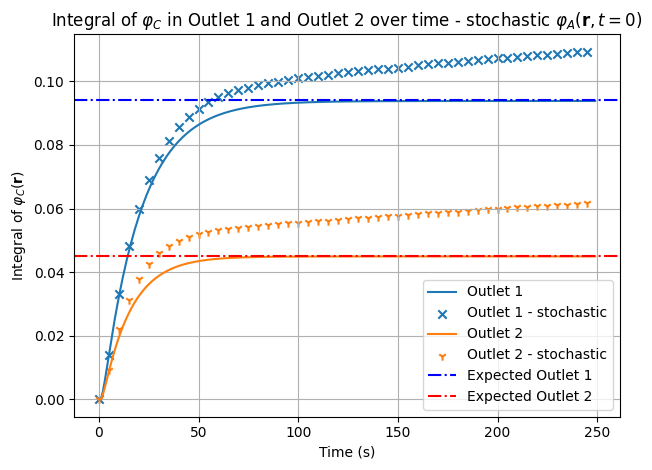

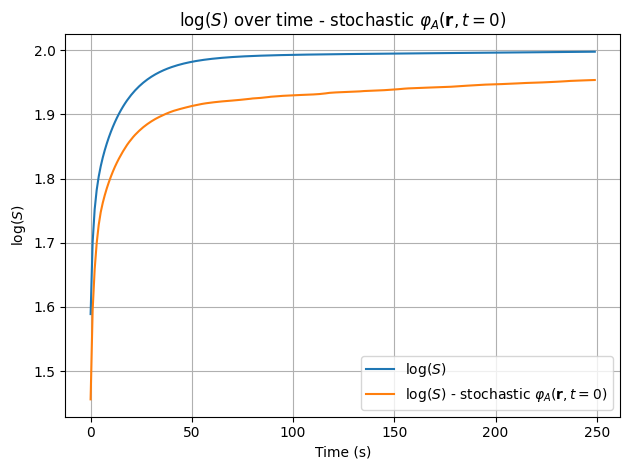

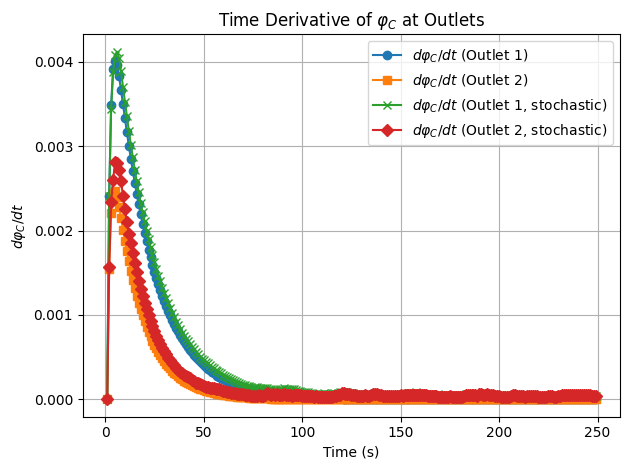

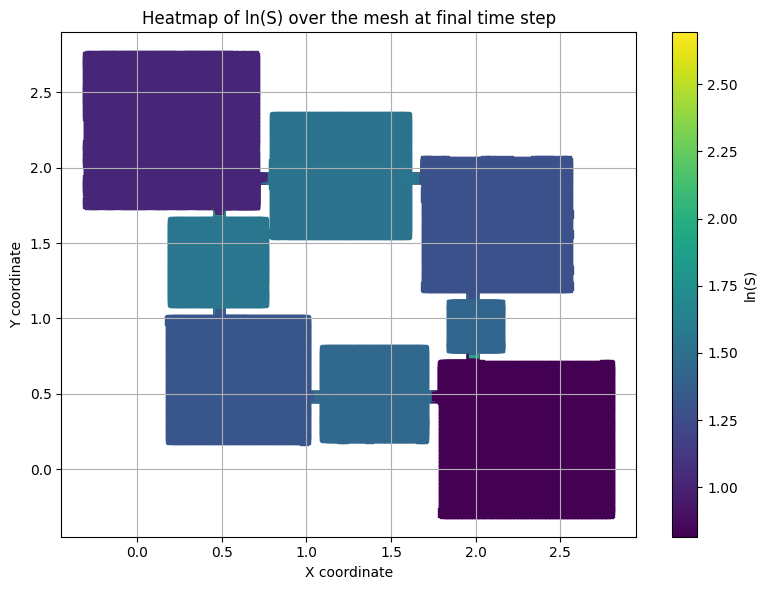

In [ ]:
# @title Plot the results - Deterministic vs Stochastic
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Define the time array
# -------------------------------
# Assuming that "steps" and "time_step" are already defined
time = np.arange(0, steps * time_step, time_step)

# --------------------------------------------------
# Plot the integral of φ_C over Outlet 1 and Outlet 2 over time
# --------------------------------------------------
plt.figure()
plt.plot(time, integral_C_outlet1_values, label='Outlet 1')
# Use slicing [::5] to select every 5th point for the scatter plot
plt.scatter(time[::5], integral_C_outlet1_noise[::5], marker='x', label='Outlet 1 - stochastic')
plt.plot(time, integral_C_outlet2_values, label='Outlet 2')
plt.scatter(time[::5], integral_C_outlet2_noise[::5], marker='1', label='Outlet 2 - stochastic')

# Horizontal lines for the expected values
plt.axhline(y=0.9425e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')

plt.xlabel('Time (s)')
plt.ylabel(r'Integral of $\varphi_C(\mathbf{r})$')
plt.title(r'Integral of $\varphi_C$ in Outlet 1 and Outlet 2 over time - stochastic $\varphi_A(\mathbf{r}, t=0)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("C_over_time_stochastic.png", dpi=300)
plt.show()

# --------------------------------------------------
# Plot the integral of S (on a logarithmic scale) over time
# --------------------------------------------------
plt.figure()
plt.plot(time, np.log10(integral_S_values), label='log($S$)')
plt.plot(time, np.log10(integral_S_noise), label=r'log($S$) - stochastic $\varphi_A(\mathbf{r}, t=0)$')
plt.xlabel('Time (s)')
plt.ylabel('log($S$)')
plt.title(r'log($S$) over time - stochastic $\varphi_A(\mathbf{r}, t=0)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("IntegralLog_stochastic-S.png", dpi=300)
plt.show()

# --------------------------------------------------
# Compute and plot the time derivative of the concentration integrals (with comparison)
# --------------------------------------------------
# Compute the derivative using finite differences (np.diff)
# NOTE: np.diff returns an array with one element less than "time"

# Derivatives for the homogeneous data
dC1_dt = np.diff(integral_C_outlet1_values) / time_step
dC2_dt = np.diff(integral_C_outlet2_values) / time_step

# Derivatives for the inhomogeneous data
dC1_inhom_dt = np.diff(integral_C_outlet1_noise) / time_step
dC2_inhom_dt = np.diff(integral_C_outlet2_noise) / time_step

plt.figure()
# Plot homogeneous data with markers
plt.plot(time[1:], dC1_dt, label=r"$d\varphi_C/dt$ (Outlet 1)", marker='o')
plt.plot(time[1:], dC2_dt, label=r"$d\varphi_C/dt$ (Outlet 2)", marker='s')
# Plot inhomogeneous data with markers
plt.plot(time[1:], dC1_inhom_dt, label=r"$d\varphi_C/dt$ (Outlet 1, stochastic)", marker='x')
plt.plot(time[1:], dC2_inhom_dt, label=r"$d\varphi_C/dt$ (Outlet 2, stochastic)", marker='D')

plt.xlabel('Time (s)')
plt.ylabel(r"$d\varphi_C/dt$")
plt.title(r"Time Derivative of $\varphi_C$ at Outlets")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Concentration_Derivatives_comparison.png", dpi=300)
plt.show()

# --------------------------------------------------
# Compute and plot the heatmap of ln(S) over the mesh at the final time step
# --------------------------------------------------
# Compute ln(S) and replace non-positive values with NaN to avoid errors
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)

# Extract the X and Y coordinates of the mesh cell centers
x = np.array(fipy_mesh.cellCenters[0])
y = np.array(fipy_mesh.cellCenters[1])

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.tight_layout()
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()


Analytical integral (unnormalized Gaussian) over R^2: 0.028793172275584818
Numerical integral over initial_region1: 0.02835803508715029
0.07189761841551161
0.07300084462410884


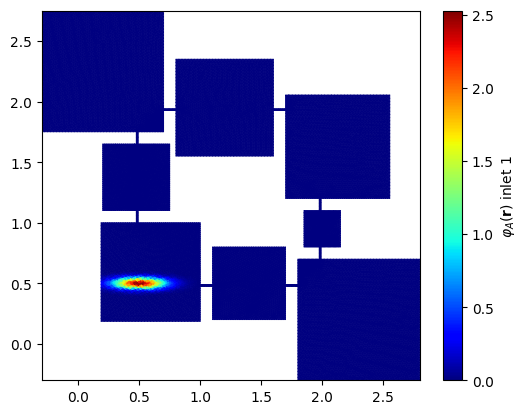

In [ ]:
# @title Plot Inhomogeneous initial distribution
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe STEFANO BASILE
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging


# Load the Gmsh mesh file directly using the file path
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")  # Replace with your actual .msh file path

# Define the concentration fields for A, B, and S
A = CellVariable(name=r"$\varphi_A(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name=r"$\varphi_B(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name=r"$\varphi_C(\mathbf{r})$", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name=r"$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)


# Define the inlets
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544004) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544004)
initial_region = initial_region1 | initial_region2

#Define the region where the initial distribution will be placed
distribution_region1 = (fipy_mesh.cellCenters[0] >= 0.2860589702) & (fipy_mesh.cellCenters[0] <=0.2860589702 + 0.27088008) & \
                  (fipy_mesh.cellCenters[1] >= 0.2860589702) & (fipy_mesh.cellCenters[1] <=0.2860589702 + 0.27088008)
distribution_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.17088008) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.17088008)
distribution_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= 0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.8) & (fipy_mesh.cellCenters[1] <= 2.15)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.2) & \
          (fipy_mesh.cellCenters[1] >= 0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=5
Inlet2=0.1


# Set A = 1 in the combined initial regions
A.setValue(Inlet1, where=distribution_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual membrane geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)
#membrane source term:


# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# --- Extract x and y cell centers from the FiPy mesh ---
X, Y = fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1]

# --- Parameters for the Gaussian: mean vector and covariance matrix ---
mu = np.array([0.5, 0.5])
Sigma = np.array([[0.021, 0],
                  [0, 0.001]])

# Specify the desired integral of the Gaussian over the domain
desired_integral = 0.07300084462410884  # Adjust this value as needed

def multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=True):
    """
    Returns the multivariate Gaussian distribution evaluated on a FiPy mesh.

    If normalize is True, the function returns the probability density
    (i.e., normalized so that the integral over R^2 is 1).
    If normalize is False, the function returns the unnormalized Gaussian:
        g(x,y) = exp[-0.5 * (x-mu)^T Sigma^{-1} (x-mu)]
    whose analytical integral over R^2 is:
        2*pi*sqrt(det(Sigma))
    """
    # Stack X and Y into a single array of positions (N x 2)
    pos = np.array([X, Y]).T

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)

    if normalize:
        # Normalization constant for the multivariate Gaussian:
        # N = sqrt((2*pi)^n * det(Sigma))
        N = np.sqrt((2 * np.pi) ** n * Sigma_det)
    else:
        N = 1.0  # If not normalizing, set N = 1

    # Compute the exponent term for each position
    fac = np.einsum('ij,jk,ik->i', pos - mu, Sigma_inv, pos - mu)

    return np.exp(-fac / 2) / N

# --- Option: Use the analytical formula for the integral ---
# If use_analytical_integral is True, we evaluate the unnormalized version,
# whose analytical integral over R^2 is known.
use_analytical_integral = False

if use_analytical_integral:
    # Compute the unnormalized Gaussian on the mesh
    Z_values_unscaled = multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=False)
    # Analytical integral over R^2 for the unnormalized Gaussian in 2D:
    # Integral = 2*pi*sqrt(det(Sigma))
    analytical_integral = 2 * np.pi * np.sqrt(np.linalg.det(Sigma))
    print("Analytical integral (unnormalized Gaussian) over R^2:", analytical_integral)
else:
    # Compute the normalized Gaussian (theoretical integral = 1 over R^2)
    Z_values_unscaled = multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=True)
    analytical_integral = 1.0
    print("Analytical integral (normalized Gaussian) over R^2:", analytical_integral)

# --- Compute the cell areas of the mesh ---
cell_areas = fipy_mesh.cellVolumes

# --- Numerically compute the integral of the Gaussian over the desired region ---
# Here, we sum for the cells belonging to initial_region1, the product of
# the Gaussian value and the cell area.
current_integral_numerical = np.sum(Z_values_unscaled[initial_region1] * cell_areas[initial_region1])
print("Numerical integral over initial_region1:", current_integral_numerical)

# --- Compute the scaling factor ---
# We want the scaled function to have an integral equal to desired_integral.
# Depending on the option, we use either the analytical integral (if the whole R^2 domain is assumed)
# or the numerical integral obtained from the mesh.
if use_analytical_integral:
    scaling_factor = desired_integral / analytical_integral
else:
    scaling_factor = desired_integral / current_integral_numerical

# Apply the scaling factor to the Gaussian values
Z_values = Z_values_unscaled * scaling_factor
# Create a FiPy CellVariable to represent Z on the mesh
Z = CellVariable(name=r"$\varphi_A(\mathbf{r})$ inlet 1", mesh=fipy_mesh, value=Z_values)

# Visualize the Gaussian distribution
viewer = Viewer(vars=Z, datamin=0, datamax=max(Z.value))
viewer.plot()
plt.savefig("Inhomogenoeus_distribution.png", dpi=300)

f=np.sum(Z.value[initial_region1]*fipy_mesh.cellVolumes[initial_region1])
g = np.sum(A.value[initial_region2]*fipy_mesh.cellVolumes[initial_region2])
print(f)
print(g)

Analytical integral (normalized Gaussian) over R^2: 1.0
Numerical integral over initial_region1: 1.000158148752519
Starting the simulation loop...
Step 0, Time: 0 s
Step 10, Time: 10 s
Step 20, Time: 20 s
Step 30, Time: 30 s
Step 40, Time: 40 s
Step 50, Time: 50 s
Step 60, Time: 60 s
Step 70, Time: 70 s
Step 80, Time: 80 s
Step 90, Time: 90 s
Step 100, Time: 100 s
Step 110, Time: 110 s
Step 120, Time: 120 s
Step 130, Time: 130 s
Step 140, Time: 140 s
Step 150, Time: 150 s
Step 160, Time: 160 s
Step 170, Time: 170 s
Step 180, Time: 180 s
Step 190, Time: 190 s
Step 200, Time: 200 s
Step 210, Time: 210 s
Step 220, Time: 220 s
Step 230, Time: 230 s
Step 240, Time: 240 s


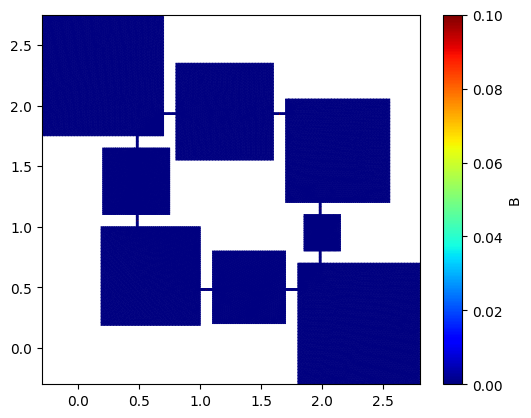

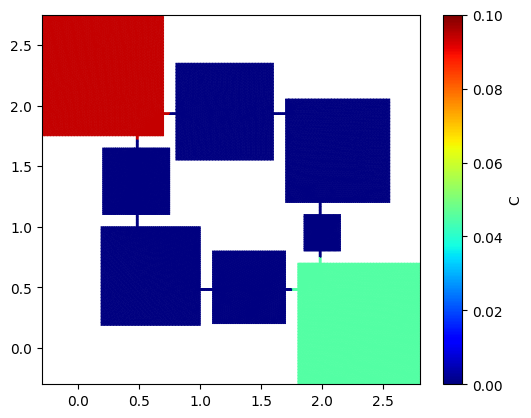

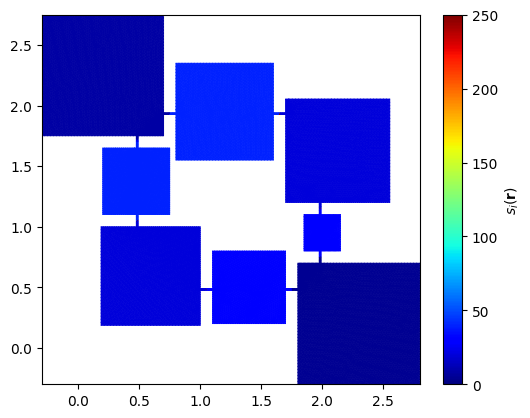

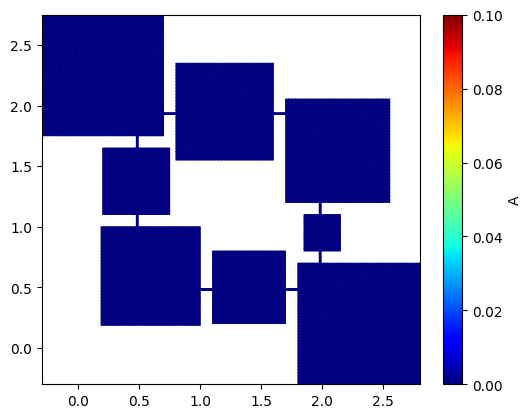

In [ ]:
# @title Linear timesteps - Inhomogeneous initial distribution
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe STEFANO BASILE
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging


# Load the Gmsh mesh file directly using the file path
# Replace with your actual .msh file path if you want to use this script as a wrapper
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")

# Define the concentration fields for A, B, and S
A = CellVariable(name="A", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name="B", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name="C", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_inhomogeneous_values = []
integral_B_outlet2_inhomogeneous_values = []
integral_C_outlet1_inhomogeneous_values = []
integral_C_outlet2_inhomogeneous_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544003745) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= -0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.75) & (fipy_mesh.cellCenters[1] <= 2.75)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.8) & \
          (fipy_mesh.cellCenters[1] >= -0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=5
Inlet2=0.1

import numpy as np

# --- Extract x and y cell centers from the FiPy mesh ---
X, Y = fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1]

# --- Parameters for the Gaussian: mean vector and covariance matrix ---
mu = np.array([0.5, 0.5])
Sigma = np.array([[0.0023, 0],
                  [0, 0.001]])

# Rescaling of the Gaussian Concentration integral to obtain the same amount of substance as in the omogeneous case
desired_integral = 0.06625

def multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=True):
    """
    Returns the multivariate Gaussian distribution evaluated on a FiPy mesh.

    If normalize is True, the function returns the probability density
    (i.e., normalized so that the integral over R^2 is 1).
    If normalize is False, the function returns the unnormalized Gaussian:
        g(x,y) = exp[-0.5 * (x-mu)^T Sigma^{-1} (x-mu)]
    whose analytical integral over R^2 is:
        2*pi*sqrt(det(Sigma))
    """
    # Stack X and Y into a single array of positions (N x 2)
    pos = np.array([X, Y]).T

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)

    if normalize:
        # Normalization constant for the multivariate Gaussian:
        # N = sqrt((2*pi)^n * det(Sigma))
        N = np.sqrt((2 * np.pi) ** n * Sigma_det)
    else:
        N = 1.0  # If not normalizing, set N = 1

    # Compute the exponent term for each position
    fac = np.einsum('ij,jk,ik->i', pos - mu, Sigma_inv, pos - mu)

    return np.exp(-fac / 2) / N

# --- Option: Use the analytical formula for the integral ---
# If use_analytical_integral is True, we evaluate the unnormalized version,
# whose analytical integral over R^2 is known.
use_analytical_integral = False

if use_analytical_integral:
    # Compute the unnormalized Gaussian on the mesh
    Z_values_unscaled = multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=False)
    # Analytical integral over R^2 for the unnormalized Gaussian in 2D:
    # Integral = 2*pi*sqrt(det(Sigma))
    analytical_integral = 2 * np.pi * np.sqrt(np.linalg.det(Sigma))
    print("Analytical integral (unnormalized Gaussian) over R^2:", analytical_integral)
else:
    # Compute the normalized Gaussian (theoretical integral = 1 over R^2)
    Z_values_unscaled = multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=True)
    analytical_integral = 1.0
    print("Analytical integral (normalized Gaussian) over R^2:", analytical_integral)

# --- Compute the cell areas of the mesh ---
cell_areas = fipy_mesh.cellVolumes

# --- Numerically compute the integral of the Gaussian over the desired region ---
# Here, we sum for the cells belonging to initial_region1, the product of
# the Gaussian value and the cell area.
current_integral_numerical = np.sum(Z_values_unscaled[initial_region1] * cell_areas[initial_region1])
print("Numerical integral over initial_region1:", current_integral_numerical)

# --- Compute the scaling factor ---
# We want the scaled function to have an integral equal to desired_integral.
# Depending on the option, we use either the analytical integral (if the whole R^2 domain is assumed)
# or the numerical integral obtained from the mesh.
if use_analytical_integral:
    scaling_factor = desired_integral / analytical_integral
else:
    scaling_factor = desired_integral / current_integral_numerical

# Apply the scaling factor to the Gaussian values
Z_values = Z_values_unscaled * scaling_factor

# Now, Z_values is the (optionally normalized) Gaussian scaled such that its
# integral (either approximated on the initial_region1 or analytically over R^2)
# matches the desired_integral.

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Set A = 1 in the combined initial regions
A.setValue(Z_values, where=initial_region1)
A.setValue(1e-10, where=reaction_zone)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual matrix geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_inlets)  # Block B from diffusing through inlets membrane
D_C.setValue(0.0, where=membrane_region_outlet)
# For B, constrain its diffusion toward the outlets (modify this to simulate directional diffusion)
flux_B = FaceVariable(mesh=fipy_mesh, rank=1)

T = 300
R = 8.314462618
# For species A:
# Original: TransientTerm(A) == DiffTerm(A) - source_term*A + source_term2*B
# Move all A/B–dependent source terms to the LHS:
#   TransientTerm(A) + source_term*A - source_term2*B == DiffTerm(A)
eq_A = (TransientTerm(var=A)
        + ImplicitSourceTerm(coeff=source_term, var=A)
        - ImplicitSourceTerm(coeff=source_term2, var=B)) \
       == DiffusionTerm(coeff=D_A, var=A)

# For species B:
# Original: TransientTerm(B) == DiffTerm(B) + source_term*A - source_term2*B - source_term3*B + source_term4*C
# Moving source terms:
#   TransientTerm(B) - source_term*A + (source_term2+source_term3)*B - source_term4*C == DiffTerm(B)
eq_B = (TransientTerm(var=B)
        - ImplicitSourceTerm(coeff=source_term, var=A)
        + ImplicitSourceTerm(coeff=(source_term2 + source_term3), var=B)
        - ImplicitSourceTerm(coeff=source_term4, var=C)) \
       == DiffusionTerm(coeff=D_B, var=B)

# For species C:
# Original: TransientTerm(C) == DiffTerm(C) + source_term3*B - source_term4*C
# Moving terms:
#   TransientTerm(C) - source_term3*B + source_term4*C == DiffTerm(C)
eq_C = (TransientTerm(var=C)
        - ImplicitSourceTerm(coeff=source_term3, var=B)
        + ImplicitSourceTerm(coeff=source_term4, var=C)) \
       == DiffusionTerm(coeff=D_C, var=C)
eq = eq_A & eq_B & eq_C
grad_A = A.grad
grad_B = B.grad
grad_C = C.grad
# Compute the magnitude squared of the gradient
grad_A_squared = numerix.dot(grad_A, grad_A)
grad_B_squared = numerix.dot(grad_B, grad_B)
grad_C_squared = numerix.dot(grad_C, grad_C)
# eq_S = TransientTerm(var=S) == (1/T)*(1 + c*A/B)*D_A*(grad_A_squared) + R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
# eq_S = TransientTerm(var=S) == (1/T)*((1 + c*1/C)*D_A*(grad_A_squared) +  (1+c2*(1/C))*D_B*(grad_B_squared))+ R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
eq_S = TransientTerm(var=S) ==(R*(1/T)*((1/A)*D_A*(grad_A_squared) +  (1/B)*D_B*(grad_B_squared) + (1/C)*D_C*(grad_C_squared)) +
                               R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
)

# Set up the viewers to visualize the concentrations of A and B
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=250)
viewer_A = Viewer(vars=A, datamin=0.0, datamax=0.1)

# Directory to save the frames
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# List to store the integral of S at each time step
integral_S_inhomogeneous_values = []

# Time-stepping parameters
time_step = 1  # ms
steps = 250  # 100*0.1 ms = Number of steps to run the simulation

# Directory to save the frames
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# Logging simulation progress
print("Starting the simulation loop...")

# Solve the equations iteratively
for step in range(steps):
    eq.solve(dt=time_step)  # Solve for all vars
    grad_phi = A.grad
    grad_B = B.grad
    grad_A_squared = numerix.dot(grad_phi, grad_phi)
    grad_B_squared = numerix.dot(grad_B, grad_B)
    grad_C_squared = numerix.dot(grad_C, grad_C)
    mixed_grad = numerix.dot(grad_phi, grad_B)
    eq_S.solve(var=S, dt=time_step)  # Solve for S
    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}, Time: {step * time_step} s")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_inhomogeneous_values.append(integral_C_outlet1)
    integral_C_outlet2_inhomogeneous_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_inhomogeneous_values.append(integral_S)  # Store the integral value

    # # Compute time derivative of S if at least two steps have been performed
    # if step > 0:
    #     dS_dt = (integral_S_values[step] - integral_S_values[step - 1]) / time_step
    #     derivative_S_values.append(dS_dt)  # Store the time derivative

    # Plot results
    viewer_A.plot()
    viewer_B.plot()
    viewer_C.plot()
    viewer_S.plot()

#     # Save figure for video
#     plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# # Create video from saved frames
# with imageio.get_writer('simulation_concA.mp4', fps=1) as video_writer:
#     for step in range(steps):
#         filename = f"{frame_dir}/frame_{step:03d}.png"
#         video_writer.append_data(imageio.imread(filename))

# # Clean up by removing saved frames
# for step in range(steps):
#    os.remove(f"{frame_dir}/frame_{step:03d}.png")


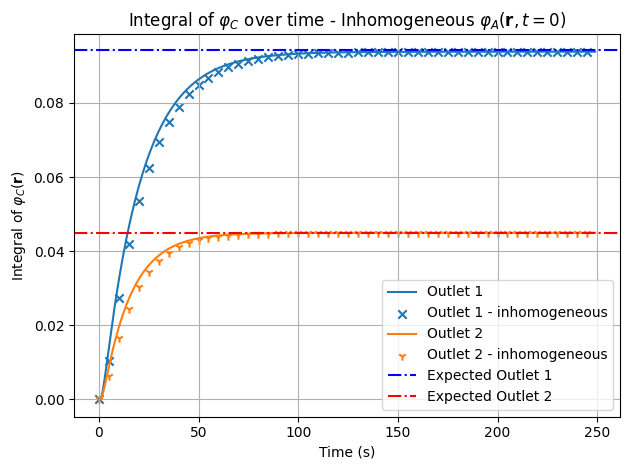

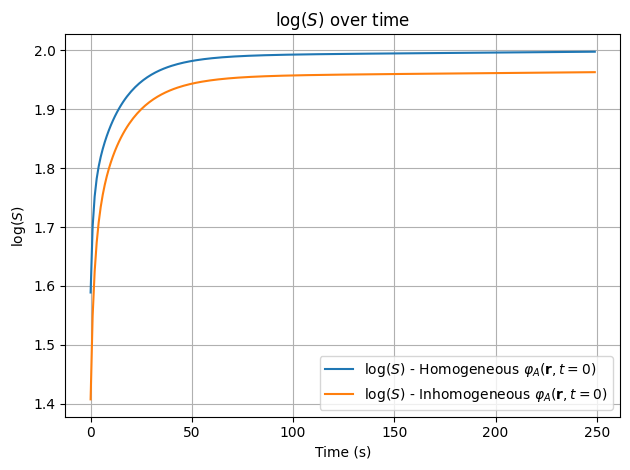

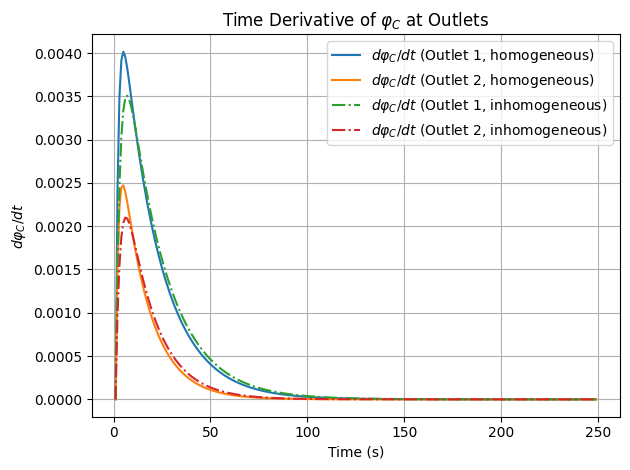

$L^2$ distance between the derivatives (Outlet 1): 0.001941825320853067
$L^2$ distance between the derivatives (Outlet 2): 0.006552586996709909
Discrete Fréchet distance between concentration derivatives (Outlet 1): 0.0008842258248382582
Discrete Fréchet distance between concentration derivatives (Outlet 2): 0.0005828112888644306
Discrete Fréchet distance between log(entropy) integrals: 0.1813421986359287
Discrete Fréchet distance between φ_C integrals (Outlet 1): 0.0015873198527796024
Discrete Fréchet distance between φ_C integrals (Outlet 2): 0.00098758759897399


In [ ]:
# @title Plot the results - Homogeneous vs Inhomogeneous
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Define the time array
# -------------------------------
# Assuming that "steps" and "time_step" are already defined
time = np.arange(0, steps * time_step, time_step)

# --------------------------------------------------
# Plot the integral of φ_C over Outlet 1 and Outlet 2 over time
# --------------------------------------------------
plt.figure()
plt.plot(time, integral_C_outlet1_values, label='Outlet 1')
# Use slicing [::5] to select every 5th point for the scatter plot
plt.scatter(time[::5], integral_C_outlet1_inhomogeneous_values[::5], marker='x', label='Outlet 1 - inhomogeneous')
plt.plot(time, integral_C_outlet2_values, label='Outlet 2')
plt.scatter(time[::5], integral_C_outlet2_inhomogeneous_values[::5], marker='1', label='Outlet 2 - inhomogeneous')

# Horizontal lines for the expected values
plt.axhline(y=0.9425e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')

plt.xlabel('Time (s)')
plt.ylabel(r'Integral of $\varphi_C(\mathbf{r})$')
plt.title(r'Integral of $\varphi_C$ over time - Inhomogeneous $\varphi_A(\mathbf{r}, t=0)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("C_over_time_inhomogeneous.png", dpi=300)
plt.show()

# --------------------------------------------------
# Plot the integral of S (on a logarithmic scale) over time
# --------------------------------------------------
plt.figure()
plt.plot(time, np.log10(integral_S_values), label=r'log($S$) - Homogeneous $\varphi_A(\mathbf{r}, t=0)$')
plt.plot(time, np.log10(integral_S_inhomogeneous_values), label=r'log($S$) - Inhomogeneous $\varphi_A(\mathbf{r}, t=0)$')
plt.xlabel('Time (s)')
plt.ylabel('log($S$) ')
plt.title(r'log($S$) over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("IntegralLog_inhomogeneous-S.png", dpi=300)
plt.show()

# --------------------------------------------------
# Compute and plot the time derivative of the concentration integrals (with comparison)
# --------------------------------------------------
# Compute the derivative using finite differences (np.diff)
# NOTE: np.diff returns an array with one element less than "time"

# Derivatives for the homogeneous data
dC1_dt = np.diff(integral_C_outlet1_values) / time_step
dC2_dt = np.diff(integral_C_outlet2_values) / time_step

# Derivatives for the inhomogeneous data
dC1_inhom_dt = np.diff(integral_C_outlet1_inhomogeneous_values) / time_step
dC2_inhom_dt = np.diff(integral_C_outlet2_inhomogeneous_values) / time_step

plt.figure()
# Plot homogeneous data with markers
plt.plot(time[1:], dC1_dt, label=r"$d\varphi_C/dt$ (Outlet 1, homogeneous)")
plt.plot(time[1:], dC2_dt, label=r"$d\varphi_C/dt$ (Outlet 2, homogeneous)")
# Plot inhomogeneous data with markers
plt.plot(time[1:], dC1_inhom_dt, linestyle="dashdot", label=r"$d\varphi_C/dt$ (Outlet 1, inhomogeneous)")
plt.plot(time[1:], dC2_inhom_dt, linestyle="dashdot", label=r"$d\varphi_C/dt$ (Outlet 2, inhomogeneous)")

plt.xlabel('Time (s)')
plt.ylabel(r"$d\varphi_C/dt$")
plt.title(r"Time Derivative of $\varphi_C$ at Outlets")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Concentration_Derivatives_comparison.png", dpi=300)
plt.show()

# Assuming dC1_dt and dC1_inhom_dt are already computed and time_step is defined:
L2_distance_1 = np.sqrt(np.sum((dC1_dt - dC1_inhom_dt)**2) * time_step)
L2_distance_2 = np.sqrt(np.sum((dC2_dt - dC1_inhom_dt)**2) * time_step)
print("$L^2$ distance between the derivatives (Outlet 1):", L2_distance_1)
print("$L^2$ distance between the derivatives (Outlet 2):", L2_distance_2)
# --- Define discrete Fréchet distance function ---
def discrete_frechet_distance(P, Q):
    """
    Compute the discrete Fréchet distance between two 1D arrays P and Q.
    Here, P and Q are assumed to be arrays of scalar values (sampled over time).

    The algorithm uses dynamic programming.
    """
    n = len(P)
    m = len(Q)
    ca = np.full((n, m), -1.0)

    def c(i, j):
        if ca[i, j] > -1:
            return ca[i, j]
        d = abs(P[i] - Q[j])
        if i == 0 and j == 0:
            ca[i, j] = d
        elif i > 0 and j == 0:
            ca[i, j] = max(c(i-1, 0), d)
        elif i == 0 and j > 0:
            ca[i, j] = max(c(0, j-1), d)
        elif i > 0 and j > 0:
            ca[i, j] = max(min(c(i-1, j), c(i-1, j-1), c(i, j-1)), d)
        else:
            ca[i, j] = float('inf')
        return ca[i, j]

    return c(n-1, m-1)

# --- Example: Using your simulation data arrays ---
# (Assuming that the following arrays are already computed over time with uniform time spacing "time_step")
#   - integral_C_outlet1_values: homogeneous case integral of φ_C at Outlet 1
#   - integral_C_outlet1_inject_values: injection case integral of φ_C at Outlet 1
#   - integral_S_values and integral_S_inject_values: corresponding integrals of S
#   - dC1_dt: finite-difference derivative (homogeneous) of integral_C_outlet1_values
#   - dC1_inhom_dt: finite-difference derivative (injection) of integral_C_outlet1_inject_values

# --- Compute discrete Fréchet distances for each pair ---
frechet_deriv_1 = discrete_frechet_distance(dC1_dt, dC1_inhom_dt)
frechet_deriv_2 = discrete_frechet_distance(dC2_dt, dC2_inhom_dt)
frechet_entropy = discrete_frechet_distance(np.log10(integral_S_values), np.log10(integral_S_inhomogeneous_values))
frechet_integralC1 = discrete_frechet_distance(integral_C_outlet1_values, integral_C_outlet1_inhomogeneous_values)
frechet_integralC2= discrete_frechet_distance(integral_C_outlet2_values, integral_C_outlet2_inhomogeneous_values)

print("Discrete Fréchet distance between concentration derivatives (Outlet 1):", frechet_deriv_1)
print("Discrete Fréchet distance between concentration derivatives (Outlet 2):", frechet_deriv_2)
print("Discrete Fréchet distance between log(entropy) integrals:", frechet_entropy)
print("Discrete Fréchet distance between φ_C integrals (Outlet 1):", frechet_integralC1)
print("Discrete Fréchet distance between φ_C integrals (Outlet 2):", frechet_integralC2)

# # --------------------------------------------------
# # Compute and plot the heatmap of ln(S) over the mesh at the final time step
# # --------------------------------------------------
# # Compute ln(S) and replace non-positive values with NaN to avoid errors
# ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)

# # Extract the X and Y coordinates of the mesh cell centers
# x = np.array(fipy_mesh.cellCenters[0])
# y = np.array(fipy_mesh.cellCenters[1])

# plt.figure(figsize=(8, 6))
# plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
# plt.colorbar(label='ln(S)')
# plt.title('Heatmap of ln(S) over the mesh at final time step')
# plt.xlabel('X coordinate')
# plt.ylabel('Y coordinate')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Heatmap_lnS.png", dpi=300)
# plt.show()


# Exponential timesteps

This code is analogous to the 2D one aside from the usage of exponentially increasing spacing between timesteps. This approach guarantees us to have finer insights in the first part of the simulation, usually associated with the highest increase in entropy.

In [ ]:
# @title Exponential timesteps - Inhomogeneous initial distribution
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe STEFANO BASILE
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging


# Load the Gmsh mesh file directly using the file path
# Replace with your actual .msh file path if you want to use this script as a wrapper
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")

# Define the concentration fields for A, B, and S
A = CellVariable(name="A", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name="B", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name="C", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_inhomogeneous_values = []
integral_B_outlet2_inhomogeneous_values = []
integral_C_outlet1_inhomogeneous_values = []
integral_C_outlet2_inhomogeneous_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544003745) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= -0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.75) & (fipy_mesh.cellCenters[1] <= 2.75)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.8) & \
          (fipy_mesh.cellCenters[1] >= -0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=5
Inlet2=0.1

import numpy as np

# --- Extract x and y cell centers from the FiPy mesh ---
X, Y = fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1]

# --- Parameters for the Gaussian: mean vector and covariance matrix ---
mu = np.array([0.5, 0.5])
Sigma = np.array([[0.0005, 0],
                  [0, 0.0005]])

# Specify the desired integral of the Gaussian over the domain
desired_integral = 0.1  # Adjust this value as needed

def multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=True):
    """
    Returns the multivariate Gaussian distribution evaluated on a FiPy mesh.

    If normalize is True, the function returns the probability density
    (i.e., normalized so that the integral over R^2 is 1).
    If normalize is False, the function returns the unnormalized Gaussian:
        g(x,y) = exp[-0.5 * (x-mu)^T Sigma^{-1} (x-mu)]
    whose analytical integral over R^2 is:
        2*pi*sqrt(det(Sigma))
    """
    # Stack X and Y into a single array of positions (N x 2)
    pos = np.array([X, Y]).T

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)

    if normalize:
        # Normalization constant for the multivariate Gaussian:
        # N = sqrt((2*pi)^n * det(Sigma))
        N = np.sqrt((2 * np.pi) ** n * Sigma_det)
    else:
        N = 1.0  # If not normalizing, set N = 1

    # Compute the exponent term for each position
    fac = np.einsum('ij,jk,ik->i', pos - mu, Sigma_inv, pos - mu)

    return np.exp(-fac / 2) / N

# --- Option: Use the analytical formula for the integral ---
# If use_analytical_integral is True, we evaluate the unnormalized version,
# whose analytical integral over R^2 is known.
use_analytical_integral = True

if use_analytical_integral:
    # Compute the unnormalized Gaussian on the mesh
    Z_values_unscaled = multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=False)
    # Analytical integral over R^2 for the unnormalized Gaussian in 2D:
    # Integral = 2*pi*sqrt(det(Sigma))
    analytical_integral = 2 * np.pi * np.sqrt(np.linalg.det(Sigma))
    print("Analytical integral (unnormalized Gaussian) over R^2:", analytical_integral)
else:
    # Compute the normalized Gaussian (theoretical integral = 1 over R^2)
    Z_values_unscaled = multivariate_gaussian_fipy(X, Y, mu, Sigma, normalize=True)
    analytical_integral = 1.0
    print("Analytical integral (normalized Gaussian) over R^2:", analytical_integral)

# --- Compute the cell areas of the mesh ---
cell_areas = fipy_mesh.cellVolumes

# --- Numerically compute the integral of the Gaussian over the desired region ---
# Here, we sum for the cells belonging to initial_region1, the product of
# the Gaussian value and the cell area.
current_integral_numerical = np.sum(Z_values_unscaled[initial_region1] * cell_areas[initial_region1])
print("Numerical integral over initial_region1:", current_integral_numerical)

# --- Compute the scaling factor ---
# We want the scaled function to have an integral equal to desired_integral.
# Depending on the option, we use either the analytical integral (if the whole R^2 domain is assumed)
# or the numerical integral obtained from the mesh.
if use_analytical_integral:
    scaling_factor = desired_integral / analytical_integral
else:
    scaling_factor = desired_integral / current_integral_numerical

# Apply the scaling factor to the Gaussian values
Z_values = Z_values_unscaled * scaling_factor

# Now, Z_values is the (optionally normalized) Gaussian scaled such that its
# integral (either approximated on the initial_region1 or analytically over R^2)
# matches the desired_integral.

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Set A = 1 in the combined initial regions
A.setValue(Z_values, where=initial_region1)
A.setValue(0.0, where=reaction_zone)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual matrix geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_inlets)  # Block B from diffusing through inlets membrane
D_C.setValue(0.0, where=membrane_region_outlet)
# For B, constrain its diffusion toward the outlets (modify this to simulate directional diffusion)
flux_B = FaceVariable(mesh=fipy_mesh, rank=1)

T = 300
R = 8.314462618
# For species A:
# Original: TransientTerm(A) == DiffTerm(A) - source_term*A + source_term2*B
# Move all A/B–dependent source terms to the LHS:
#   TransientTerm(A) + source_term*A - source_term2*B == DiffTerm(A)
eq_A = (TransientTerm(var=A)
        + ImplicitSourceTerm(coeff=source_term, var=A)
        - ImplicitSourceTerm(coeff=source_term2, var=B)) \
       == DiffusionTerm(coeff=D_A, var=A)

# For species B:
# Original: TransientTerm(B) == DiffTerm(B) + source_term*A - source_term2*B - source_term3*B + source_term4*C
# Moving source terms:
#   TransientTerm(B) - source_term*A + (source_term2+source_term3)*B - source_term4*C == DiffTerm(B)
eq_B = (TransientTerm(var=B)
        - ImplicitSourceTerm(coeff=source_term, var=A)
        + ImplicitSourceTerm(coeff=(source_term2 + source_term3), var=B)
        - ImplicitSourceTerm(coeff=source_term4, var=C)) \
       == DiffusionTerm(coeff=D_B, var=B)

# For species C:
# Original: TransientTerm(C) == DiffTerm(C) + source_term3*B - source_term4*C
# Moving terms:
#   TransientTerm(C) - source_term3*B + source_term4*C == DiffTerm(C)
eq_C = (TransientTerm(var=C)
        - ImplicitSourceTerm(coeff=source_term3, var=B)
        + ImplicitSourceTerm(coeff=source_term4, var=C)) \
       == DiffusionTerm(coeff=D_C, var=C)
eq = eq_A & eq_B & eq_C
grad_A = A.grad
grad_B = B.grad
grad_C = C.grad
# Compute the magnitude squared of the gradient
grad_A_squared = numerix.dot(grad_A, grad_A)
grad_B_squared = numerix.dot(grad_B, grad_B)
grad_C_squared = numerix.dot(grad_C, grad_C)
# eq_S = TransientTerm(var=S) == (1/T)*(1 + c*A/B)*D_A*(grad_A_squared) + R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
# eq_S = TransientTerm(var=S) == (1/T)*((1 + c*1/C)*D_A*(grad_A_squared) +  (1+c2*(1/C))*D_B*(grad_B_squared))+ R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
eq_S = TransientTerm(var=S) ==(R*(1/T)*((1/A)*D_A*(grad_A_squared) +  (1/B)*D_B*(grad_B_squared) + (1/C)*D_C*(grad_C_squared)) +
                               R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
)
# Set up the viewers to visualize the concentrations of A and B
#viewer_A = Viewer(vars=A, datamin=0.0, datamax=0.2)
#viewer_B = Viewer(vars=B, datamin=0.0, datamax=0.2)
#viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0)
#viewer_S = Viewer(vars=S, datamin=0.0, datamax=3e2)

# Directory to save the frames
#frame_dir = "frames"
#os.makedirs(frame_dir, exist_ok=True)


# Lists to store the integrals of B over outlet1 and outlet2 at each time step
integral_C_outlet1_exponential_values = []
integral_C_outlet2_exponential_values = []
# List to store the integral of S at each time step
integral_S_exponential_values = []

# Time-stepping parameters
start_time = 1e-6  # Smallest time step in ms
end_time = 1     # Largest time step in ms
total_time = 100.0 # Total simulation time in ms
num_steps = 500    # Total number of steps

# Generate geometrically spaced timesteps and normalize to fit total_time
raw_timesteps = np.geomspace(start_time, end_time, num=num_steps)
timesteps = raw_timesteps * (total_time / sum(raw_timesteps))  # Normalize timesteps
cumulative_time = np.cumsum(timesteps)  # Calculate cumulative time for plotting

# Solve the equations iteratively
for step, time_step in enumerate(timesteps):
    eq.solve(dt=time_step)  # Solve for A, B, and C
    grad_phi = A.grad
    grad_phi_squared = numerix.dot(grad_phi, grad_phi)
    eq_S.solve(var=S, dt=time_step)  # Solve for S

    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_exponential_values.append(integral_C_outlet1)
    integral_C_outlet2_exponential_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_exponential_values.append(integral_S)  # Store the integral value

    # Plot results
    #viewer_A.plot()
    #viewer_B.plot()
    #viewer_C.plot()
    #viewer_S.plot()

    # Save figure for video
    #plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# Create video from saved frames
#with imageio.get_writer('simulation_gradS_expnormalized.mp4', fps=48) as video_writer:
#    for step in range(num_steps):
#        filename = f"{frame_dir}/frame_{step:03d}.png"
#        video_writer.append_data(imageio.imread(filename))

# Clean up by removing saved frames
#for step in range(num_steps):
#    os.remove(f"{frame_dir}/frame_{step:03d}.png")

# Plot the integral of B over outlet1 and outlet2 over cumulative time
plt.figure()
plt.plot(cumulative_time, integral_C_outlet1_exponential_values, label='Outlet 1')
plt.plot(cumulative_time, integral_C_outlet2_exponential_values, label='Outlet 2')
plt.axhline(y=0.7925e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (s)')
plt.ylabel('Integral of $C(\mathbf{r})$')
plt.title('Integral of $C(\mathbf{r})$ in Outlet 1 and Outlet 2 over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.legend()
plt.savefig("C_over_time_ExponentialNormalized_outlets.png", dpi=300)
plt.show()

# Plot the integral of S over cumulative time
plt.figure()
plt.plot(np.log10(cumulative_time), np.log10(integral_S_exponential_values))
plt.xlabel('Time (s)')
plt.ylabel('Integral of log(S)')
plt.title('Integral of log(S) over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.savefig("IntegralLN-S_ExponentialNormalized.png", dpi=300)
plt.show()

# # Plot the time derivative of the integral of S over time
# time_values = np.arange(1, steps * time_step, time_step)  # Time array starting from step 1
# plt.figure()
# plt.plot(time_values, derivative_S_values, label='dS/dt', marker='s')
# plt.xlabel('Time (ms)')
# plt.ylabel('dS/dt')
# plt.title('Time derivative of the integral of S over time')
# plt.grid(True)
# plt.legend()
# plt.show()





Analytical integral (unnormalized Gaussian) over R^2: 0.0031415926535897937
Numerical integral over initial_region1: 0.0031427116178628116


<ipython-input-29-48b03ba4b36e>:244: RuntimeWarning: divide by zero encountered in log
  R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))


Step 0
Step 10
Step 20
Step 30
Step 40


KeyboardInterrupt: 

Step 0
Step 10
Step 20
Step 30
Step 40
Step 50
Step 60
Step 70
Step 80
Step 90
Step 100
Step 110
Step 120
Step 130
Step 140
Step 150
Step 160
Step 170
Step 180
Step 190
Step 200
Step 210
Step 220
Step 230
Step 240
Step 250
Step 260
Step 270
Step 280
Step 290
Step 300
Step 310
Step 320
Step 330
Step 340
Step 350
Step 360
Step 370
Step 380
Step 390
Step 400
Step 410
Step 420
Step 430
Step 440
Step 450
Step 460
Step 470
Step 480
Step 490


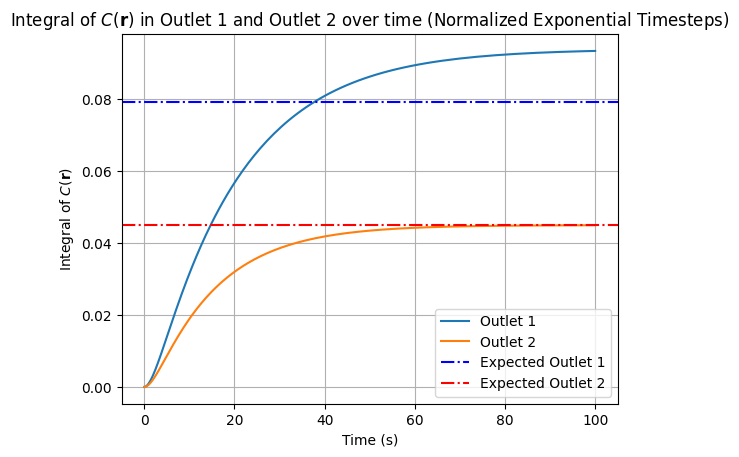

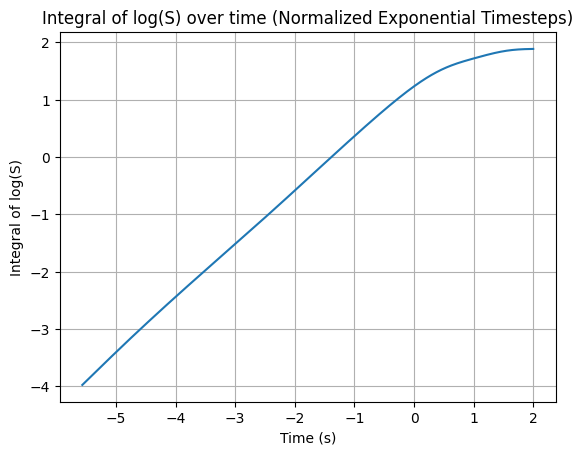

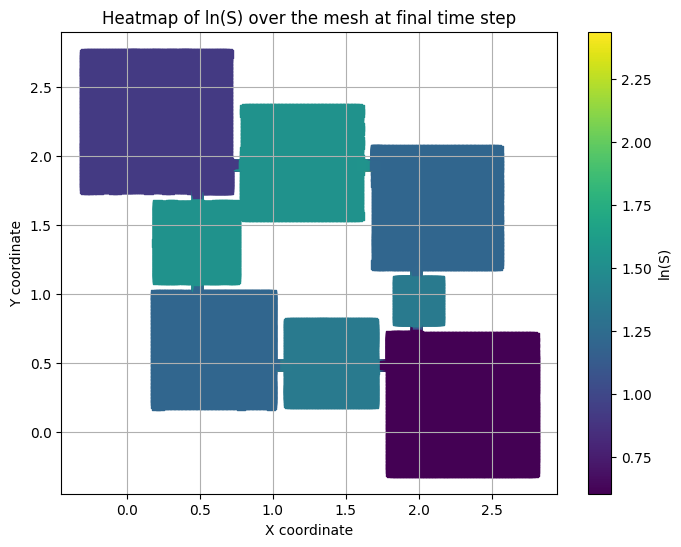

In [ ]:
# @title Exponential Timesteps - Sharp D Values
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging


# Load the Gmsh mesh file directly using the file path
# Replace with your actual .msh file path if you want to use this script as a wrapper
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")

# Define the concentration fields for A, B, and S
A = CellVariable(name=r"$\varphi_A(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name=r"$\varphi_B(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name=r"$\varphi_C(\mathbf{r})$", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_values = []
integral_B_outlet2_values = []
integral_C_outlet1_values = []
integral_C_outlet2_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544003745) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= -0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.75) & (fipy_mesh.cellCenters[1] <= 2.75)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.8) & \
          (fipy_mesh.cellCenters[1] >= -0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=0.1
Inlet2=0.1


# Set A = 1 in the combined initial regions
A.setValue(Inlet1, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual membrane geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_inlets)  # Block B from diffusing through any membrane
D_C.setValue(0.0, where=membrane_region_outlet)

T = 300
R = 8.314462618

# Define the diffusion-reaction equations with directional diffusion and implicit source terms
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B +source_term4*C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
eq = eq_A & eq_B & eq_C
grad_A = A.grad
grad_B = B.grad
grad_C = C.grad
# Compute the magnitude squared of the gradient
grad_A_squared = numerix.dot(grad_A, grad_A)
grad_B_squared = numerix.dot(grad_B, grad_B)
grad_C_squared = numerix.dot(grad_C, grad_C)
eq_S = TransientTerm(var=S) == R*(1/T)*((1/A)*D_A*(grad_A_squared) +  (1/B)*D_B*(grad_B_squared) + (1/C)*D_C*(grad_C_squared)) + \
       R * (np.log((k*A+1e-12)/(k2*B+1e-12)) * (k*A - k2*B)) +  R * (np.log((k_on*B+1e-10)/(k_off*C)) * (k_on*B - k_off*C))

# Set up the viewers to visualize the concentrations of A and B
#viewer_A = Viewer(vars=A, datamin=0.0, datamax=0.2)
#viewer_B = Viewer(vars=B, datamin=0.0, datamax=0.2)
#viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0)
#viewer_S = Viewer(vars=S, datamin=0.0, datamax=3e2)

# Directory to save the frames
#frame_dir = "frames"
#os.makedirs(frame_dir, exist_ok=True)


# Lists to store the integrals of B over outlet1 and outlet2 at each time step
integral_C_outlet1_exponential_values = []
integral_C_outlet2_exponential_values = []
# List to store the integral of S at each time step
integral_S_exponential_values = []

# Time-stepping parameters
start_time = 1e-6  # Smallest time step in ms
end_time = 1     # Largest time step in ms
total_time = 100.0 # Total simulation time in ms
num_steps = 500    # Total number of steps

# Generate geometrically spaced timesteps and normalize to fit total_time
raw_timesteps = np.geomspace(start_time, end_time, num=num_steps)
timesteps = raw_timesteps * (total_time / sum(raw_timesteps))  # Normalize timesteps
cumulative_time = np.cumsum(timesteps)  # Calculate cumulative time for plotting

# Solve the equations iteratively
for step, time_step in enumerate(timesteps):
    eq.solve(dt=time_step)  # Solve for A, B, and C
    grad_phi = A.grad
    grad_phi_squared = numerix.dot(grad_phi, grad_phi)
    eq_S.solve(var=S, dt=time_step)  # Solve for S

    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_exponential_values.append(integral_C_outlet1)
    integral_C_outlet2_exponential_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_exponential_values.append(integral_S)  # Store the integral value

    # Plot results
    #viewer_A.plot()
    #viewer_B.plot()
    #viewer_C.plot()
    #viewer_S.plot()

    # Save figure for video
    #plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# Create video from saved frames
#with imageio.get_writer('simulation_gradS_expnormalized.mp4', fps=48) as video_writer:
#    for step in range(num_steps):
#        filename = f"{frame_dir}/frame_{step:03d}.png"
#        video_writer.append_data(imageio.imread(filename))

# Clean up by removing saved frames
#for step in range(num_steps):
#    os.remove(f"{frame_dir}/frame_{step:03d}.png")

# Plot the integral of B over outlet1 and outlet2 over cumulative time
plt.figure()
plt.plot(cumulative_time, integral_C_outlet1_exponential_values, label='Outlet 1')
plt.plot(cumulative_time, integral_C_outlet2_exponential_values, label='Outlet 2')
plt.axhline(y=0.7925e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (s)')
plt.ylabel('Integral of $C(\mathbf{r})$')
plt.title('Integral of $C(\mathbf{r})$ in Outlet 1 and Outlet 2 over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.legend()
plt.savefig("C_over_time_ExponentialNormalized_outlets.png", dpi=300)
plt.show()

# Plot the integral of S over cumulative time
plt.figure()
plt.plot(np.log10(cumulative_time), np.log10(integral_S_exponential_values))
plt.xlabel('Time (s)')
plt.ylabel('Integral of log(S)')
plt.title('Integral of log(S) over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.savefig("IntegralLN-S_ExponentialNormalized.png", dpi=300)
plt.show()

# # Plot the time derivative of the integral of S over time
# time_values = np.arange(1, steps * time_step, time_step)  # Time array starting from step 1
# plt.figure()
# plt.plot(time_values, derivative_S_values, label='dS/dt', marker='s')
# plt.xlabel('Time (ms)')
# plt.ylabel('dS/dt')
# plt.title('Time derivative of the integral of S over time')
# plt.grid(True)
# plt.legend()
# plt.show()

# Compute and plot heatmap of ln(S) over the mesh at the last time step
ln_S = np.log10(S.value)  # Compute ln(S), handle potential issues with S <= 0 by avoiding these values
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)  # Replace negative or zero values with NaN for safe plotting

# Generate heatmap of ln(S) using the mesh coordinates
x = np.array(fipy_mesh.cellCenters[0])  # X coordinates of the mesh cells
y = np.array(fipy_mesh.cellCenters[1])  # Y coordinates of the mesh cells

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()

In the following, we defined a subset of the inlets to start from a non-equilibrium inhomogeneous distribution of molecules A, simulation parameters remain unchanged.

In [ ]:
# Plot the integral of B over outlet1 and outlet2 over cumulative time
plt.figure()
plt.plot(cumulative_time, integral_C_outlet1_values, label='Outlet 1')
plt.plot(cumulative_time, integral_C_outlet2_values, label='Outlet 2')
plt.axhline(y=0.7925e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (s)')
plt.ylabel('Integral of $C(\mathbf{r})$')
plt.title('Integral of $C(\mathbf{r})$ in Outlet 1 and Outlet 2 over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.legend()
plt.savefig("C_over_time_ExponentialNormalized_outlets.png", dpi=300)
plt.show()

# Plot the integral of S over cumulative time
plt.figure()
plt.plot(cumulative_time, np.log10(integral_S_values))
plt.xlabel('Time (s)')
plt.ylabel('Integral of log(S)')
plt.title('Integral of log(S) over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.savefig("IntegralLN-S_ExponentialNormalized.png", dpi=300)
plt.show()

# # Plot the time derivative of the integral of S over time
# time_values = np.arange(1, steps * time_step, time_step)  # Time array starting from step 1
# plt.figure()
# plt.plot(time_values, derivative_S_values, label='dS/dt', marker='s')
# plt.xlabel('Time (ms)')
# plt.ylabel('dS/dt')
# plt.title('Time derivative of the integral of S over time')
# plt.grid(True)
# plt.legend()
# plt.show()

# Compute and plot heatmap of ln(S) over the mesh at the last time step
ln_S = np.log10(S.value)  # Compute ln(S), handle potential issues with S <= 0 by avoiding these values
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)  # Replace negative or zero values with NaN for safe plotting

# Generate heatmap of ln(S) using the mesh coordinates
x = np.array(fipy_mesh.cellCenters[0])  # X coordinates of the mesh cells
y = np.array(fipy_mesh.cellCenters[1])  # Y coordinates of the mesh cells

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined

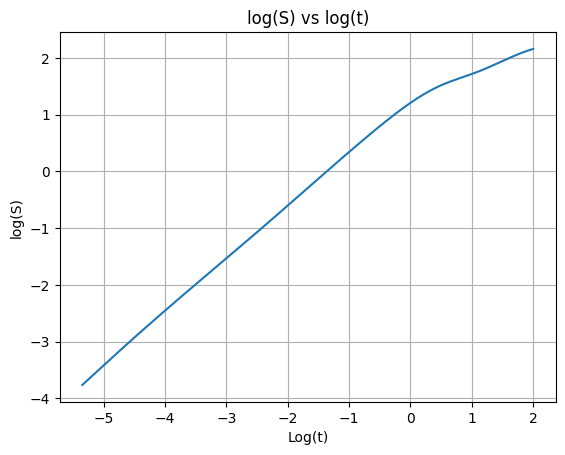

In [ ]:
# Plot the integral of S over time
plt.figure()
plt.plot(np.log10(cumulative_time), np.log10(integral_S_values))
plt.xlabel('Log(t)')
plt.ylabel('log(S)')
plt.title('log(S) vs log(t)')
plt.grid(True)
plt.savefig("IntegralLN-S.png", dpi=300)
plt.show()


In the next code section we plot the results of our computations in the context of inhomogeneous initial distribution of $\varphi_A(\mathbf{r})$.

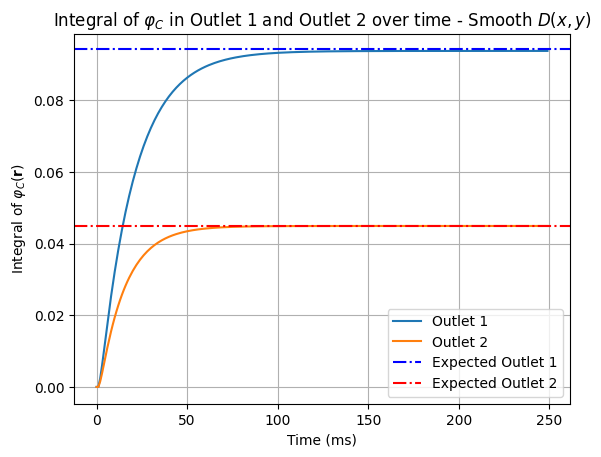

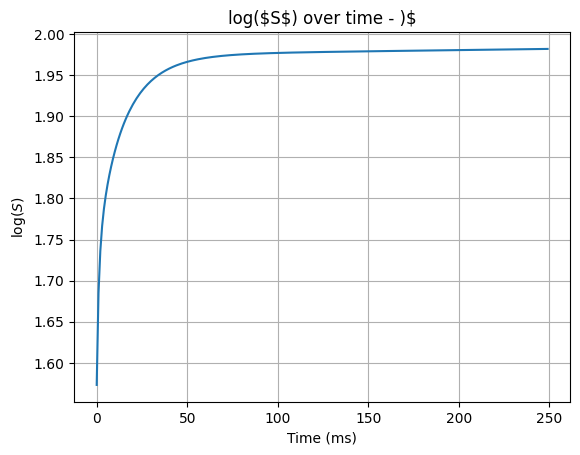

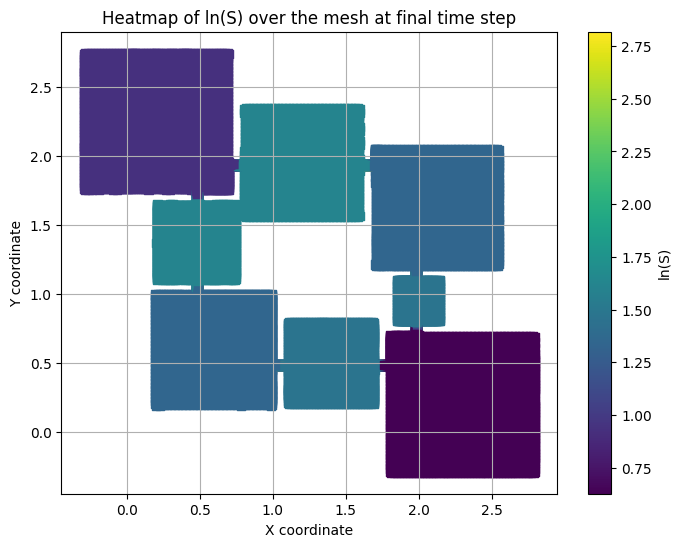

In [ ]:
# Plot the integral of B over outlet1 and outlet2 over time
plt.figure()
plt.plot(np.arange(0, steps * time_step, time_step), integral_C_outlet1_values, label='Outlet 1')
plt.plot(np.arange(0, steps * time_step, time_step), integral_C_outlet2_values, label='Outlet 2')
plt.axhline(y=0.9425e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (ms)')
plt.ylabel(r'Integral of $\varphi_C (\mathbf{r})$')
plt.title(r'Integral of $\varphi_C$ in Outlet 1 and Outlet 2 over time - Smooth $D(x,y)$')
plt.legend()
plt.grid(True)
plt.savefig("C_over_time_inhomogenous.png", dpi=300)
plt.show()

# Plot the integral of S over time
plt.figure()
plt.plot(np.arange(0, steps * time_step, time_step), np.log10(integral_S_values))
plt.xlabel('Time (ms)')
plt.ylabel('log($S$)')
plt.title('log($S$) over time - )$')
plt.grid(True)
plt.savefig("IntegralLN_inhomogeneous-S.png", dpi=300)
plt.show()

# # Plot the time derivative of the integral of S over time
# time_values = np.arange(1, steps * time_step, time_step)  # Time array starting from step 1
# plt.figure()
# plt.plot(time_values, derivative_S_values, label='dS/dt', marker='s')
# plt.xlabel('Time (ms)')
# plt.ylabel('dS/dt')
# plt.title('Time derivative of the integral of S over time')
# plt.grid(True)
# plt.legend()
# plt.show()

# Compute and plot heatmap of ln(S) over the mesh at the last time step
ln_S = np.log10(S.value)  # Compute ln(S), handle potential issues with S <= 0 by avoiding these values
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)  # Replace negative or zero values with NaN for safe plotting

# Generate heatmap of ln(S) using the mesh coordinates
x = np.array(fipy_mesh.cellCenters[0])  # X coordinates of the mesh cells
y = np.array(fipy_mesh.cellCenters[1])  # Y coordinates of the mesh cells

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()

# Linear Timesteps: 3D

The code is analogous to the 2D version, aside from importing a different viewer due to how fipy handles 3D visualization and the obvious modifications of the .msh files.

In [ ]:
!pip install mayavi

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMBER_OF_THREADS"] = "1"
from fipy import Gmsh3D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging


# Load the Gmsh mesh file directly using the file path
fipy_mesh = Gmsh3D("/content/drive/MyDrive/Colab Notebooks/3D matrix_fine2.msh")  # Replace with your actual .msh file path

# Define the concentration fields for A, B, and S
A = CellVariable(name="A", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name="B", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name="C", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="s_i", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_values = []
integral_B_outlet2_values = []
integral_C_outlet1_values = []
integral_C_outlet2_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1) & \
                  (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544004) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544004) & \
                  (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= 0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.8) & (fipy_mesh.cellCenters[1] <= 2.15) & \
          (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.2) & \
          (fipy_mesh.cellCenters[1] >= 0.3) & (fipy_mesh.cellCenters[1] <= 0.7) & \
          (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
outlet = outlet1 | outlet2

Inlet1=1
Inlet2=1


# Set A = 1 in the combined initial regions
A.setValue(Inlet1, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual membrane geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55) & \
                  (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B<
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)   # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)
# Set diffusion coefficient for A inside the membrane to 0 (no diffusion through membrane)
#D_A.setValue(100.9, where=membrane_region)

# Set diffusion coefficient for B inside the membrane to 0 (B cannot diffuse through membrane)
D_B.setValue(0.0, where=membrane_region)
D_C.setValue(0.0, where=membrane_region)
# Optionally, you can set different values for the diffusion coefficients outside the membrane
D_A.setValue(1900.00, where=outside_membrane_region) #1e-2 ms
D_B.setValue(800.00, where=outside_membrane_region)

# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)
#membrane source term:


# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1

membrane_region6 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & \
                   (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region7 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region8 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & \
                   (fipy_mesh.cellCenters[1] >= 1.645) & (fipy_mesh.cellCenters[1] <= 1.675) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)
membrane_region9 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & \
                   (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975) & \
                   (fipy_mesh.cellCenters[2] >= 0) & (fipy_mesh.cellCenters[2] <= 1)

# Combine all membrane regions, including the original one
membrane_region_combined = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4
membrane_region_outlet = membrane_region6 | membrane_region7 | membrane_region8 | membrane_region9

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_combined)  # Block B from diffusing through any membrane
D_C.setValue(0.0, where=membrane_region_outlet)
# For B, constrain its diffusion toward the outlets (modify this to simulate directional diffusion)
flux_B = FaceVariable(mesh=fipy_mesh, rank=1)

c = 1
c2= 1
T = 300
R = 8.02
# Define the diffusion-reaction equations with directional diffusion and implicit source terms
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B +source_term4*C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
eq = eq_A & eq_B & eq_C
grad_phi = A.grad
grad_B = B.grad
# Compute the magnitude squared of the gradient
grad_phi_squared = numerix.dot(grad_phi, grad_phi)
grad_B_squared = numerix.dot(grad_B, grad_B)
eq_S = TransientTerm(var=S) == (R*((1 + c*1/C)*D_A*(grad_phi_squared) +  (1+c2*(1/C))*D_B*(grad_B_squared))+
                               R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
                               )

# Set up the viewers to visualize the concentrations of A and B
#viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0)
#viewer_B = Viewer(vars=B, datamin=0.0, datamax=3.0)
#viewer_C = Viewer(vars=C, datamin=0.0, datamax=3.0)
#viewer_S = Viewer(vars=S, datamin=0.0, datamax=5e5)

# Time-stepping parameters
time_step = 1  # ms
steps = 300  # 100*0.1 ms = Number of steps to run the simulation

# Directory to save the frames
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# Lists to store the integrals of B over outlet1 and outlet2 at each time step
integral_C_outlet1_values = []
integral_C_outlet2_values = []
# List to store the integral of S at each time step
integral_S_values = []
# List to store the time derivative of the integral of S
derivative_S_values = []

# Solve the equations iteratively
for step in range(steps):
    eq.solve(dt=time_step)  # Solve for A
    grad_phi = A.grad
    grad_phi_squared = numerix.dot(grad_phi, grad_phi)
    eq_S.solve(var=S, dt=time_step)  # Solve for S
    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}, Time: {step * time_step} ms")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_values.append(integral_C_outlet1)
    integral_C_outlet2_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_values.append(integral_S)  # Store the integral value

    # # Compute time derivative of S if at least two steps have been performed
    # if step > 0:
    #     dS_dt = (integral_S_values[step] - integral_S_values[step - 1]) / time_step
    #     derivative_S_values.append(dS_dt)  # Store the time derivative

    # Plot results
    viewer_A.plot()
    viewer_B.plot()
    viewer_C.plot()
    viewer_S.plot()

    # Save figure for video
    plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# Create video from saved frames
with imageio.get_writer('simulation_gradS_nonorm_completeBranch.mp4', fps=48) as video_writer:
    for step in range(steps):
        filename = f"{frame_dir}/frame_{step:03d}.png"
        video_writer.append_data(imageio.imread(filename))

# Clean up by removing saved frames
for step in range(steps):
    os.remove(f"{frame_dir}/frame_{step:03d}.png")

# Plot the integral of B over outlet1 and outlet2 over time
plt.figure()
plt.plot(np.arange(0, steps * time_step, time_step), integral_C_outlet1_values, label='Outlet 1')
plt.plot(np.arange(0, steps * time_step, time_step), integral_C_outlet2_values, label='Outlet 2')
plt.axhline(y=0.7925e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (ms)')
plt.ylabel('Integral of B')
plt.title('Integral of C in Outlet 1 and Outlet 2 over time')
plt.grid(True)
plt.legend()
plt.savefig("C_over_time_Matrix_outlets.png", dpi=300)
plt.show()

# Plot the integral of S over time
plt.figure()
plt.plot(np.arange(0, steps * time_step, time_step), np.log10(integral_S_values))
plt.xlabel('Time (ms)')
plt.ylabel('Integral of log(S)')
plt.title('Integral of log(S) over time')
plt.grid(True)
plt.savefig("IntegralLN-S.png", dpi=300)
plt.show()

# # Plot the time derivative of the integral of S over time
# time_values = np.arange(1, steps * time_step, time_step)  # Time array starting from step 1
# plt.figure()
# plt.plot(time_values, derivative_S_values, label='dS/dt', marker='s')
# plt.xlabel('Time (ms)')
# plt.ylabel('dS/dt')
# plt.title('Time derivative of the integral of S over time')
# plt.grid(True)
# plt.legend()
# plt.show()

# Compute and plot heatmap of ln(S) over the mesh at the last time step
ln_S = np.log10(S.value)  # Compute ln(S), handle potential issues with S <= 0 by avoiding these values
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)  # Replace negative or zero values with NaN for safe plotting

# Generate heatmap of ln(S) using the mesh coordinates
x = np.array(fipy_mesh.cellCenters[0])  # X coordinates of the mesh cells
y = np.array(fipy_mesh.cellCenters[1])  # Y coordinates of the mesh cells

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()


# Continuous *D(x,y)* functions at membranes

<ipython-input-8-db12e2bf580e>:132: RuntimeWarning: overflow encountered in exp
  (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region12))) + 1)) *
<ipython-input-8-db12e2bf580e>:133: RuntimeWarning: overflow encountered in exp
  (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region11))) + 1)) *
<ipython-input-8-db12e2bf580e>:135: RuntimeWarning: overflow encountered in exp
  (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region9))) + 1)) *
<ipython-input-8-db12e2bf580e>:138: RuntimeWarning: overflow encountered in exp
  (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region10))) + 1))
<ipython-input-8-db12e2bf580e>:148: RuntimeWarning: overflow encountered in exp
  (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region4))) + 1)) *
/usr/local/lib/python3.11/dist-packages/fipy/variables/unaryOperatorVariable.py:36: RuntimeWarning: overflow encountered in exp
  v

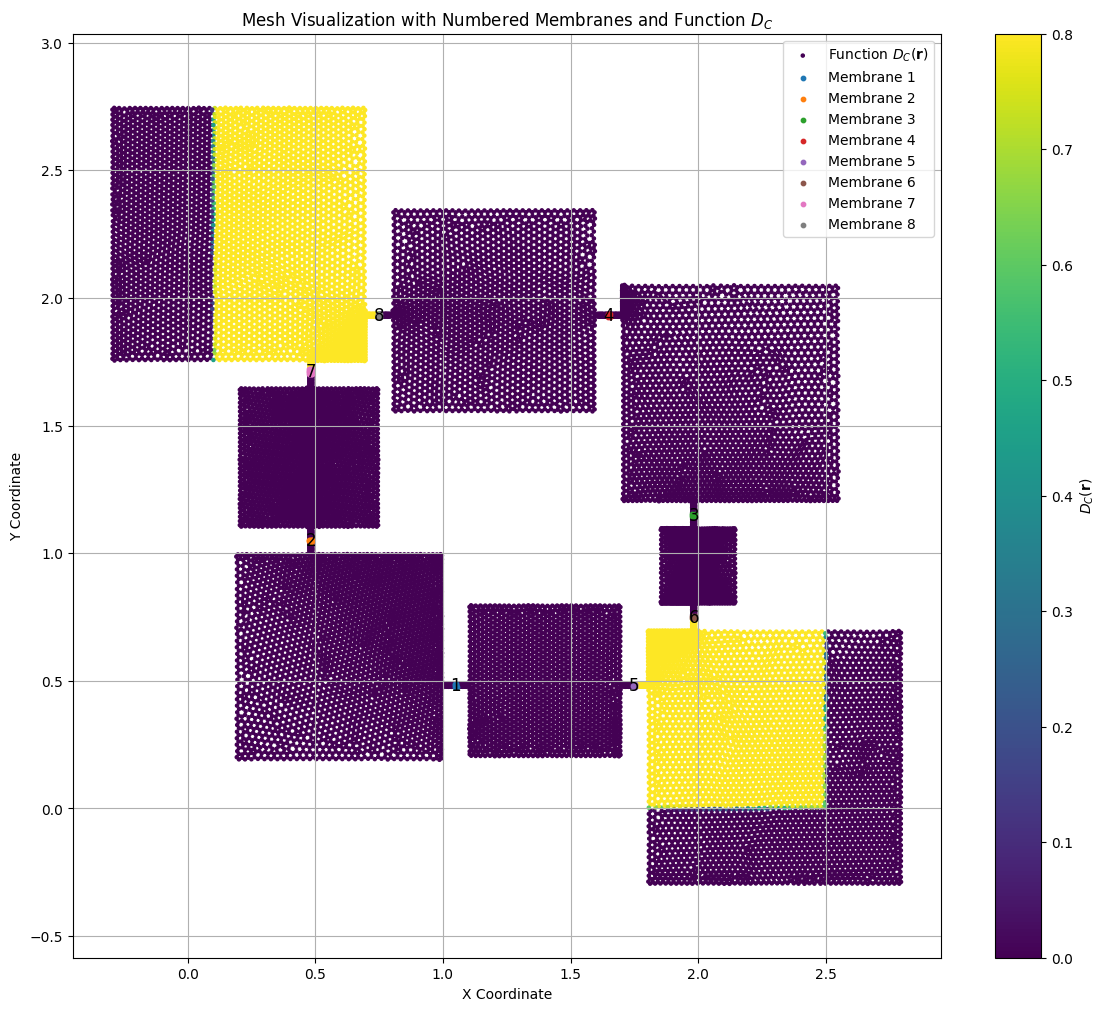

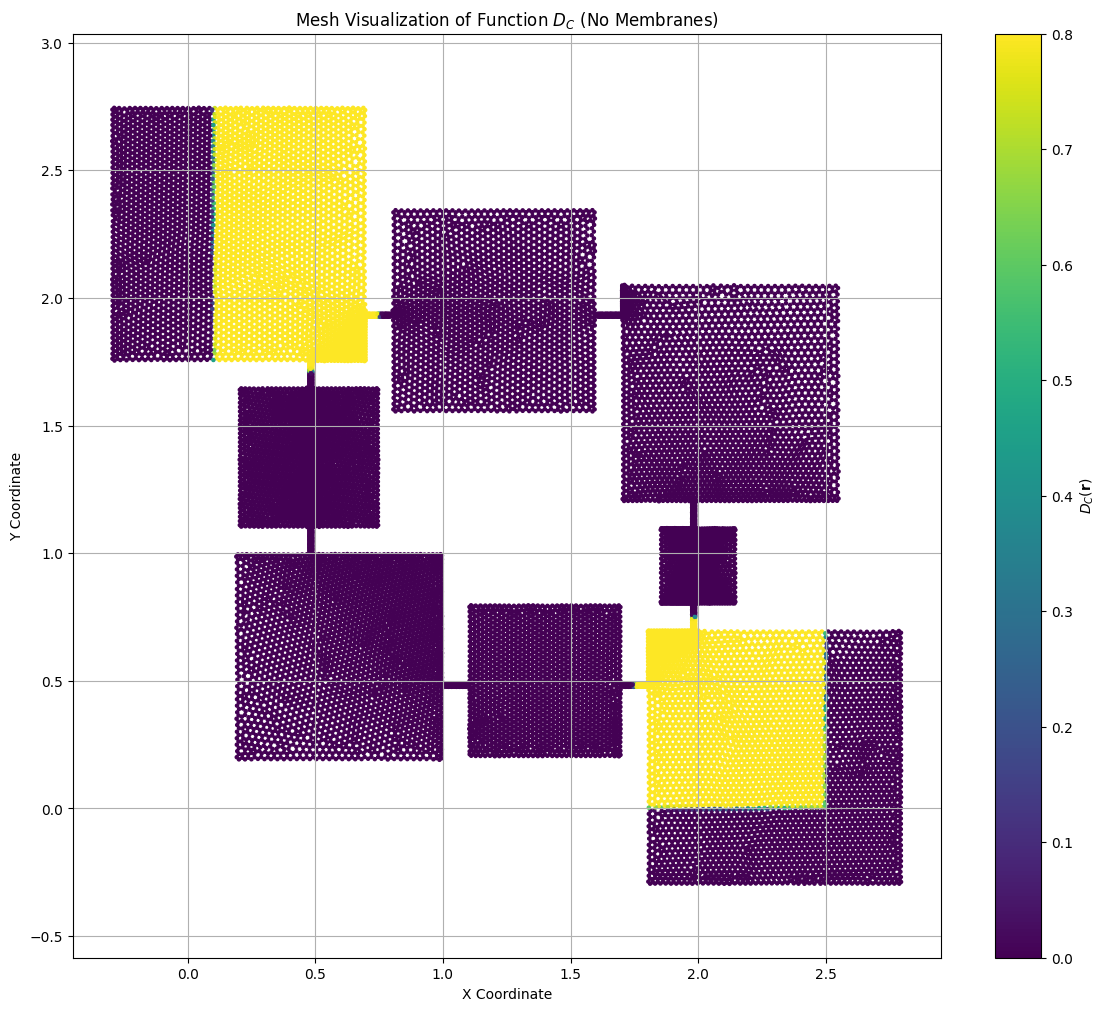

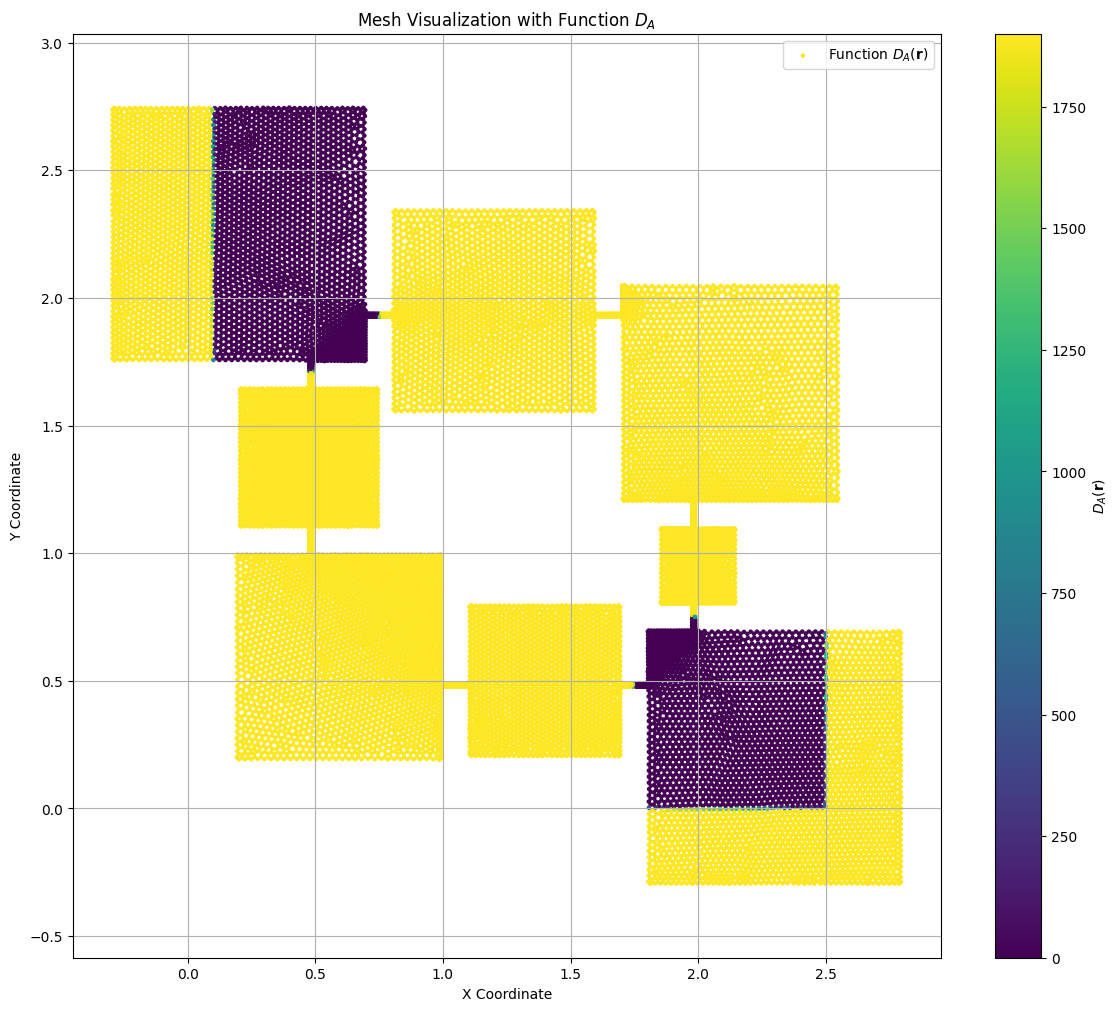

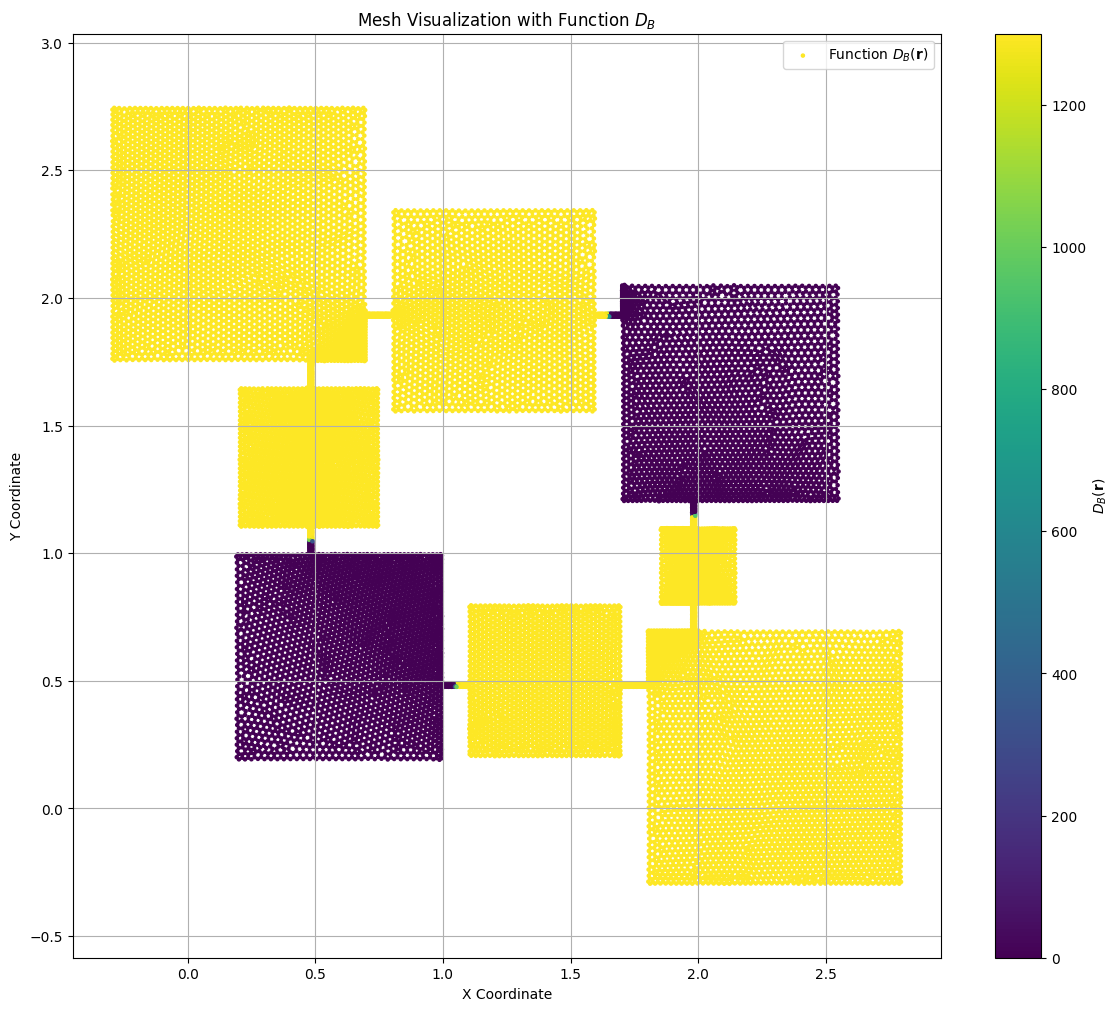

In [ ]:
# @title Plotting the Diffusion Coefficient Functions
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging

# Load the Gmsh mesh file directly using the file path
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")  # Sostituisci con il percorso effettivo del file .msh

# Define the concentration fields for A, B, C and S
A = CellVariable(name="$\varphi_A(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name="$\varphi_B(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name="$\varphi_C(\mathbf{r})$", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_smooth_values = []
integral_B_outlet2_smooth_values = []
integral_C_outlet1_smooth_values = []
integral_C_outlet2_smooth_values = []

# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <= 1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544004) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544004)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= 0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.8) & (fipy_mesh.cellCenters[1] <= 2.15)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.2) & \
          (fipy_mesh.cellCenters[1] >= 0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1 = 1
Inlet2 = 1

# Set A = 1 in the combined initial regions
A.setValue(Inlet1, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane regions (adattare in base alla geometria effettiva)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                   (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A, B, and C
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # \(\mu m^2/ms\)
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)
D_C = CellVariable(mesh=fipy_mesh, value=0.80)

# Define the reaction rate constants
k = 1
k2 = 0.000001
k_on = 0.1
k_off = 1e-6

# Create the source term variables
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: complemento della regione iniziale
reaction_zone = ~initial_region

# Applica il termine sorgente nella zona di reazione
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)

# Definisci ulteriori regioni della membrana per outlet (con larghezza 0.1)
membrane_region9  = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95)  & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7)   & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combina le regioni della membrana (originali e per outlet)
membrane_region_combined = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12

# Estrai le coordinate dei centri delle celle
x, y = fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1]

# Definisci i maschere per ciascuna regione della membrana
membrane_regions = {
    1: membrane_region1,
    2: membrane_region2,
    3: membrane_region3,
    4: membrane_region4,
    5: membrane_region9,
    6: membrane_region10,
    7: membrane_region11,
    8: membrane_region12
}

# Funzioni per calcolare il centro di una regione della membrana
def center_x_membrane(region):
    return np.mean(x[region.value])

def center_y_membrane(region):
    return np.mean(y[region.value])

# Definisci la funzione f e calcola D_C_value
f = 400
D_C_value = 0.80*(
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - 0.1)) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region12))) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region11))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - 4)) + 1)) +
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region9))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - 2.5)) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1])) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region10))) + 1))
)

D_A_value = -(1900/0.8)*D_C_value + 1900

D_B_value_helper = 1300*(
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - 0.)) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region1))) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1])) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region2))) + 1)) +
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region4))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - 4)) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region3))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - 3)) + 1))
)
D_B_value = -D_B_value_helper + 1300

# =======================
# Plot di D_C con le membrane (prima immagine)
# =======================
plt.figure(figsize=(14, 12))
sc = plt.scatter(fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1], c=D_C_value, s=5, cmap="viridis", label="Function $D_C(\\mathbf{r})$")
plt.colorbar(sc, label="$D_C(\\mathbf{r})$")
# Evidenzia ed etichetta le regioni della membrana
for idx, (num, region) in enumerate(membrane_regions.items(), start=1):
    mask = region.value
    plt.scatter(x[mask], y[mask], s=10, label=f"Membrane {num}")
    if np.any(mask):
        x_center = np.mean(x[mask])
        y_center = np.mean(y[mask])
        plt.text(x_center, y_center, str(num), fontsize=12, color="black", ha="center", va="center")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Mesh Visualization with Numbered Membranes and Function $D_C$")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.savefig("D_C_membranes.png", dpi=300)
plt.show()

# =======================
# Plot di D_C SENZA le membrane (seconda immagine)
# =======================
plt.figure(figsize=(14, 12))
sc = plt.scatter(fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1], c=D_C_value, s=5, cmap="viridis")
plt.colorbar(sc, label="$D_C(\\mathbf{r})$")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Mesh Visualization of Function $D_C$ (No Membranes)")
plt.axis("equal")
plt.grid(True)
plt.savefig("D_C_no_membranes.png", dpi=300)
plt.show()

# =======================
# Plot della funzione D_A
# =======================
plt.figure(figsize=(14, 12))
sc = plt.scatter(fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1], c=D_A_value, s=5, cmap="viridis", label="Function $D_A(\\mathbf{r})$")
plt.colorbar(sc, label="$D_A(\\mathbf{r})$")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Mesh Visualization with Function $D_A$")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.savefig("D_A.png", dpi=300)
plt.show()

# =======================
# Plot della funzione D_B
# =======================
plt.figure(figsize=(14, 12))
sc = plt.scatter(fipy_mesh.cellCenters[0], fipy_mesh.cellCenters[1], c=D_B_value, s=5, cmap="viridis", label="Function $D_B(\\mathbf{r})$")
plt.colorbar(sc, label="$D_B(\\mathbf{r})$")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Mesh Visualization with Function $D_B$")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.savefig("D_B.png", dpi=300)
plt.show()


Starting the simulation loop...
Step 0, Time: 0 ms
Step 10, Time: 10 ms
Step 20, Time: 20 ms
Step 30, Time: 30 ms
Step 40, Time: 40 ms
Step 50, Time: 50 ms
Step 60, Time: 60 ms
Step 70, Time: 70 ms
Step 80, Time: 80 ms
Step 90, Time: 90 ms
Step 100, Time: 100 ms
Step 110, Time: 110 ms
Step 120, Time: 120 ms
Step 130, Time: 130 ms
Step 140, Time: 140 ms
Step 150, Time: 150 ms
Step 160, Time: 160 ms
Step 170, Time: 170 ms
Step 180, Time: 180 ms
Step 190, Time: 190 ms
Step 200, Time: 200 ms
Step 210, Time: 210 ms
Step 220, Time: 220 ms
Step 230, Time: 230 ms
Step 240, Time: 240 ms


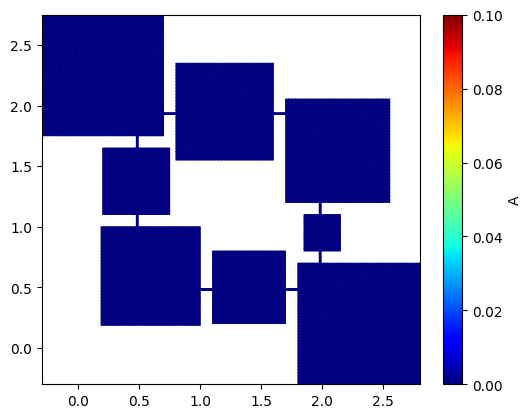

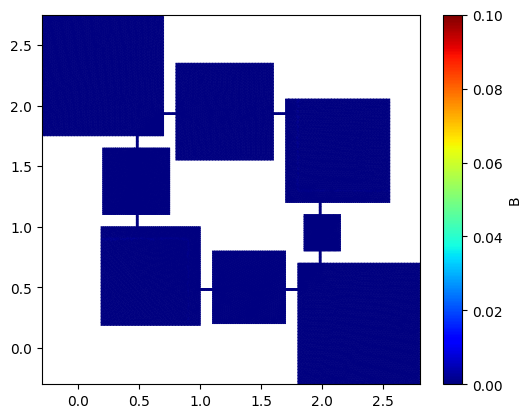

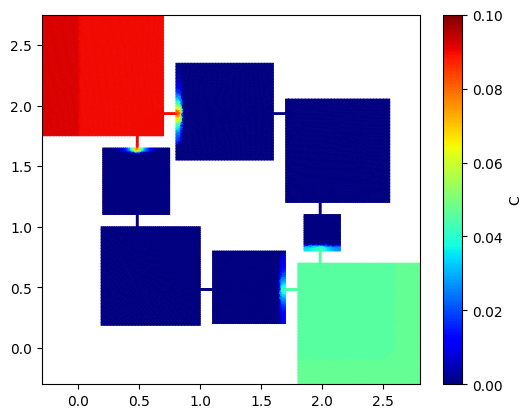

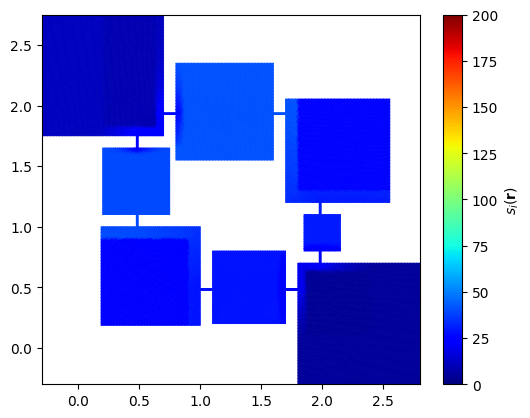

In [ ]:
# @title Linear timesteps - Smooth D(x,y)
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe
"""
import os
# Enable FIPY_Inline flag for performance
os.environ["FIPY_Inline"] = "1"
os.environ["FIPY_SOLVER"] = "pysparse"
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio
import logging

# Load the Gmsh mesh file directly using the file path
# Replace with your actual .msh file path if you want to use this script as a wrapper
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine5.msh")

# Define the concentration fields for A, B, and S
A = CellVariable(name="A", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name="B", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name="C", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_smooth_values = []
integral_B_outlet2_smooth_values = []
integral_C_outlet1_smooth_values = []
integral_C_outlet2_smooth_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544003745) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544003745)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= -0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.75) & (fipy_mesh.cellCenters[1] <= 2.75)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.8) & \
          (fipy_mesh.cellCenters[1] >= -0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=0.1
Inlet2=0.1


# Set A = 1 in the combined initial regions
A.setValue(Inlet1, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual membrane geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)
#membrane source term:


# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_inlets)  # Block B from diffusing through any membrane
D_C.setValue(0.0, where=membrane_region_outlet)

def center_x_membrane(membrane_region):
  mean_x = numerix.mean(fipy_mesh.cellCenters[0][membrane_region])
  return mean_x
def center_y_membrane(membrane_region):
  mean_y = numerix.mean(fipy_mesh.cellCenters[1][membrane_region])
  return mean_y
f = 150
D_C_value = 0.80*(
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - 0.1)) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region12))) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region11))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - 4)) + 1)) +
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region9))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - 2.5)) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1])) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region10))) + 1))
)
D_A_value = -(1900/0.8)*D_C_value+1900
D_B_value_helper = 1300*(
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - 0.)) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region1))) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] )) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] -center_y_membrane(membrane_region2))) + 1)) +
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region4))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - 4)) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region3))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - 3)) + 1))
)
D_B_value= -D_B_value_helper+1300

# Assign the computed values to the membrane regions
D_C.setValue(D_C_value)
D_A.setValue(D_A_value)
D_B.setValue(D_B_value)

T = 300
R = 8.314462618
# Define the diffusion-reaction equations with directional diffusion and implicit source terms
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B +source_term4*C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
eq = eq_A & eq_B & eq_C
grad_A = A.grad
grad_B = B.grad
grad_C = C.grad
# Compute the magnitude squared of the gradient
grad_A_squared = numerix.dot(grad_A, grad_A)
grad_B_squared = numerix.dot(grad_B, grad_B)
grad_C_squared = numerix.dot(grad_C, grad_C)
eq_S = TransientTerm(var=S) == R*(1/T)*((1/A)*D_A*(grad_A_squared) +  (1/B)*D_B*(grad_B_squared) + (1/C)*D_C*(grad_C_squared))+ \
      R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))

# Set up the viewers to visualize the concentrations of A and B
viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0e-1)
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1.0e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=200)

# Time-stepping parameters
time_step = 1  # ms
steps = 250  # 100*0.1 ms = Number of steps to run the simulation

# Directory to save the frames
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# Logging simulation progress
print("Starting the simulation loop...")

# List to store the integral of S at each time step
integral_S_smooth_values = []
# List to store the time derivative of the integral of S
derivative_S_values = []

# Solve the equations iteratively
for step in range(steps):
    eq.solve(dt=time_step)  # Solve for all vars
    grad_phi = A.grad
    grad_B = B.grad
    grad_A_squared = numerix.dot(grad_phi, grad_phi)
    grad_B_squared = numerix.dot(grad_B, grad_B)
    grad_C_squared = numerix.dot(grad_C, grad_C)
    mixed_grad = numerix.dot(grad_phi, grad_B)
    eq_S.solve(var=S, dt=time_step)  # Solve for S
    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}, Time: {step * time_step} ms")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_smooth_values.append(integral_C_outlet1)
    integral_C_outlet2_smooth_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_smooth_values.append(integral_S)  # Store the integral value

    # # Compute time derivative of S if at least two steps have been performed
    # if step > 0:
    #     dS_dt = (integral_S_values[step] - integral_S_values[step - 1]) / time_step
    #     derivative_S_values.append(dS_dt)  # Store the time derivative

    # Plot results
    #viewer_A.plot()
    #viewer_B.plot()
    #viewer_C.plot()
    #viewer_S.plot()

    # Save figure for video
    #plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# Create video from saved frames
#with imageio.get_writer('simulation_gradS_nonorm_completeBranch.mp4', fps=48) as video_writer:
  #  for step in range(steps):
   #     filename = f"{frame_dir}/frame_{step:03d}.png"
    #    video_writer.append_data(imageio.imread(filename))

# Clean up by removing saved frames
#for step in range(steps):
  #  os.remove(f"{frame_dir}/frame_{step:03d}.png")
# Plot results
viewer_A.plot()
viewer_B.plot()
viewer_C.plot()
viewer_S.plot()




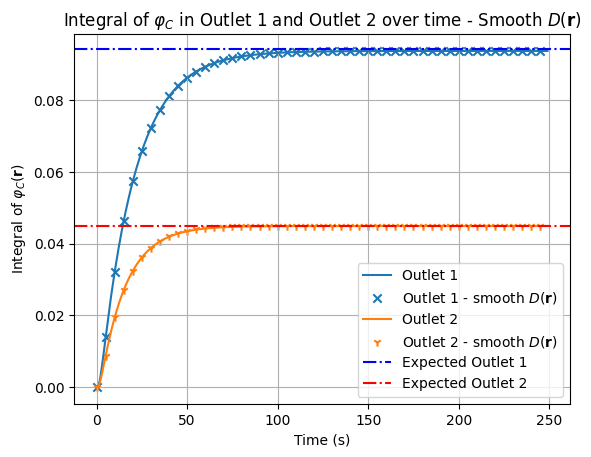

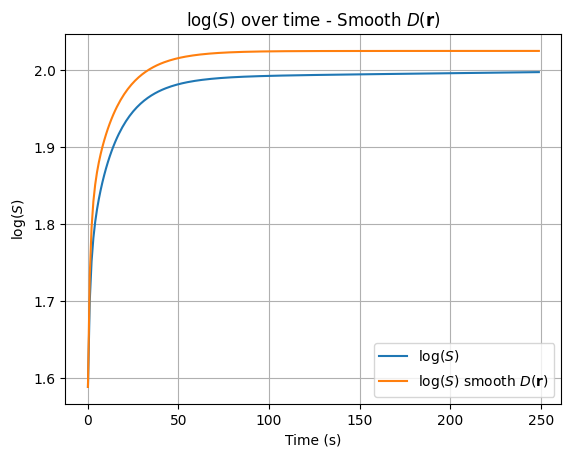

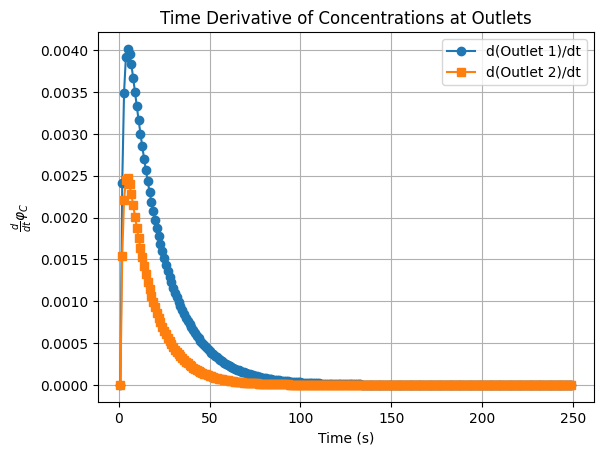

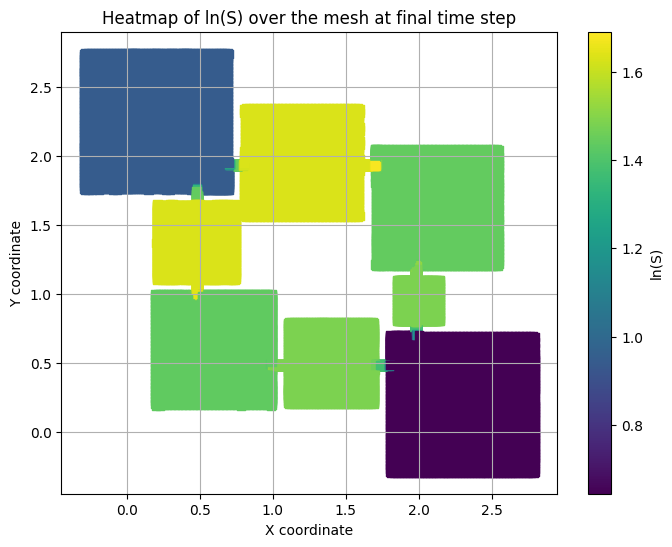

In [ ]:
# @title Plotting the results
# Create the time array once for convenience
time = np.arange(0, steps * time_step, time_step)

# Plot the integral of B over outlet1 and outlet2 over time
plt.figure()
plt.plot(time, integral_C_outlet1_values, label='Outlet 1')
# Use slicing [::5] to select every 5th point for the scatter plot
plt.scatter(time[::5], integral_C_outlet1_smooth_values[::5], marker='x', label='Outlet 1 - smooth $D(\mathbf{r})$')
plt.plot(time, integral_C_outlet2_values, label='Outlet 2')
plt.scatter(time[::5], integral_C_outlet2_smooth_values[::5], marker='1', label='Outlet 2 - smooth $D(\mathbf{r})$')
plt.axhline(y=0.9425e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (s)')
plt.ylabel(r'Integral of $\varphi_C (\mathbf{r})$')
plt.title(r'Integral of $\varphi_C$ in Outlet 1 and Outlet 2 over time - Smooth $D(\mathbf{r})$')
plt.legend()
plt.grid(True)
plt.savefig("C_over_time_SmoothD.png", dpi=300)
plt.show()

# Plot the integral of S over time
plt.figure()
plt.plot(time, np.log10(integral_S_values), label='log($S$)')
plt.plot(time, np.log10(D_smooth_S_f400), label='log($S$) smooth $D(\mathbf{r})$')
plt.xlabel('Time (s)')
plt.ylabel('log($S$)')
plt.title('log($S$) over time - Smooth $D(\mathbf{r})$')
plt.legend()
plt.grid(True)
plt.savefig("IntegralLog_SmoothD-S.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# Compute and plot the time derivative of the concentration integrals
# Using finite differences (np.diff), which yields one less point:
dC1_dt = np.diff(integral_C_outlet1_values) / time_step
dC2_dt = np.diff(integral_C_outlet2_values) / time_step

plt.figure()
# Plot against time[1:] since np.diff reduces the length by one.
plt.plot(time[1:], dC1_dt, label='d(Outlet 1)/dt', marker='o')
plt.plot(time[1:], dC2_dt, label='d(Outlet 2)/dt', marker='s')
plt.xlabel('Time (s)')
plt.ylabel(r'$\frac{{d}}{{{d}t}}\varphi_C}$')
plt.title('Time Derivative of Concentrations at Outlets')
plt.legend()
plt.grid(True)
plt.savefig("Concentration_Derivatives.png", dpi=300)
plt.show()

# Compute and plot heatmap of ln(S) over the mesh at the last time step
# Compute ln(S) and handle potential issues with S <= 0 by replacing them with NaN
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)

# Generate heatmap of ln(S) using the mesh coordinates
x = np.array(fipy_mesh.cellCenters[0])  # X coordinates of the mesh cells
y = np.array(fipy_mesh.cellCenters[1])  # Y coordinates of the mesh cells

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()


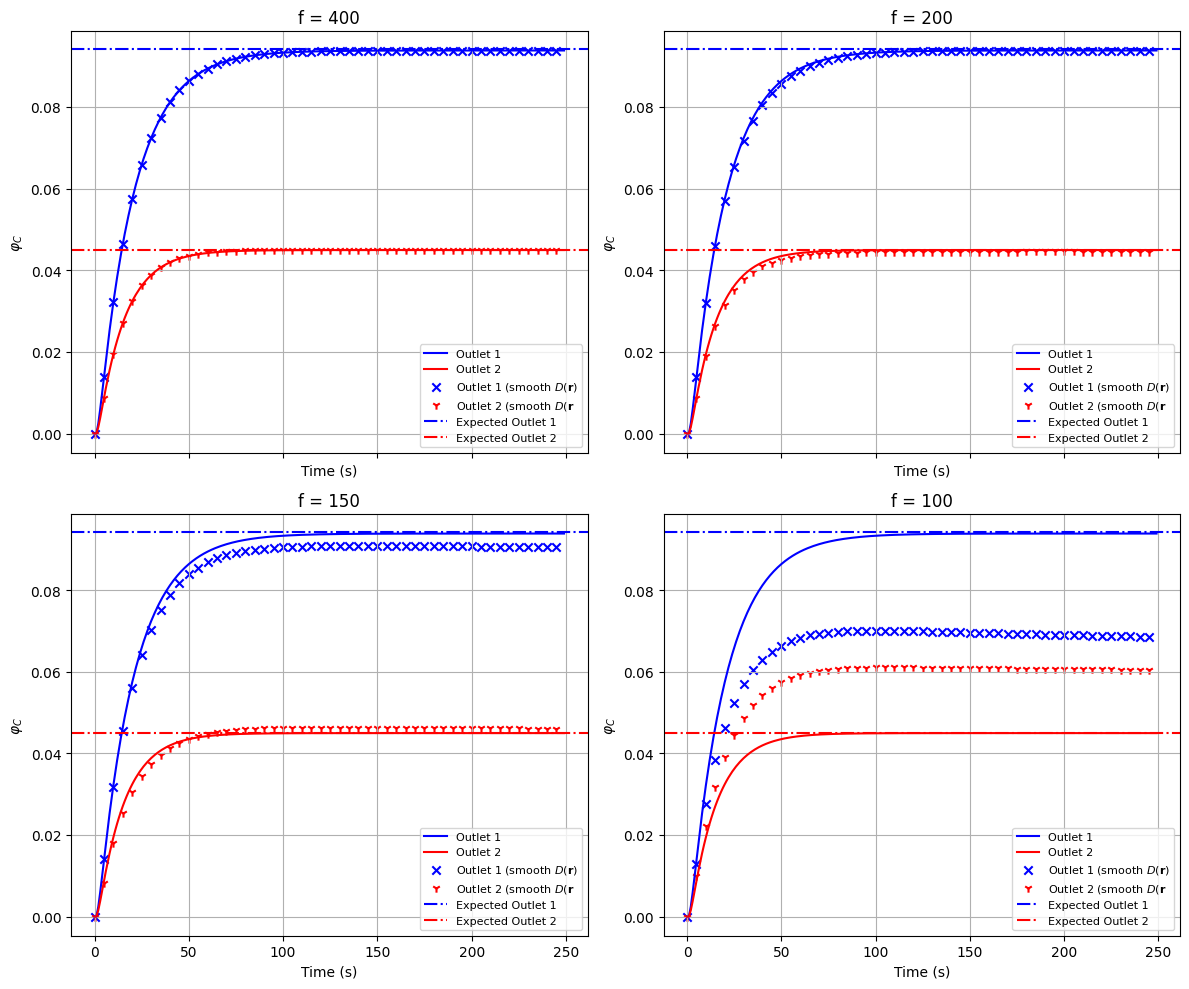

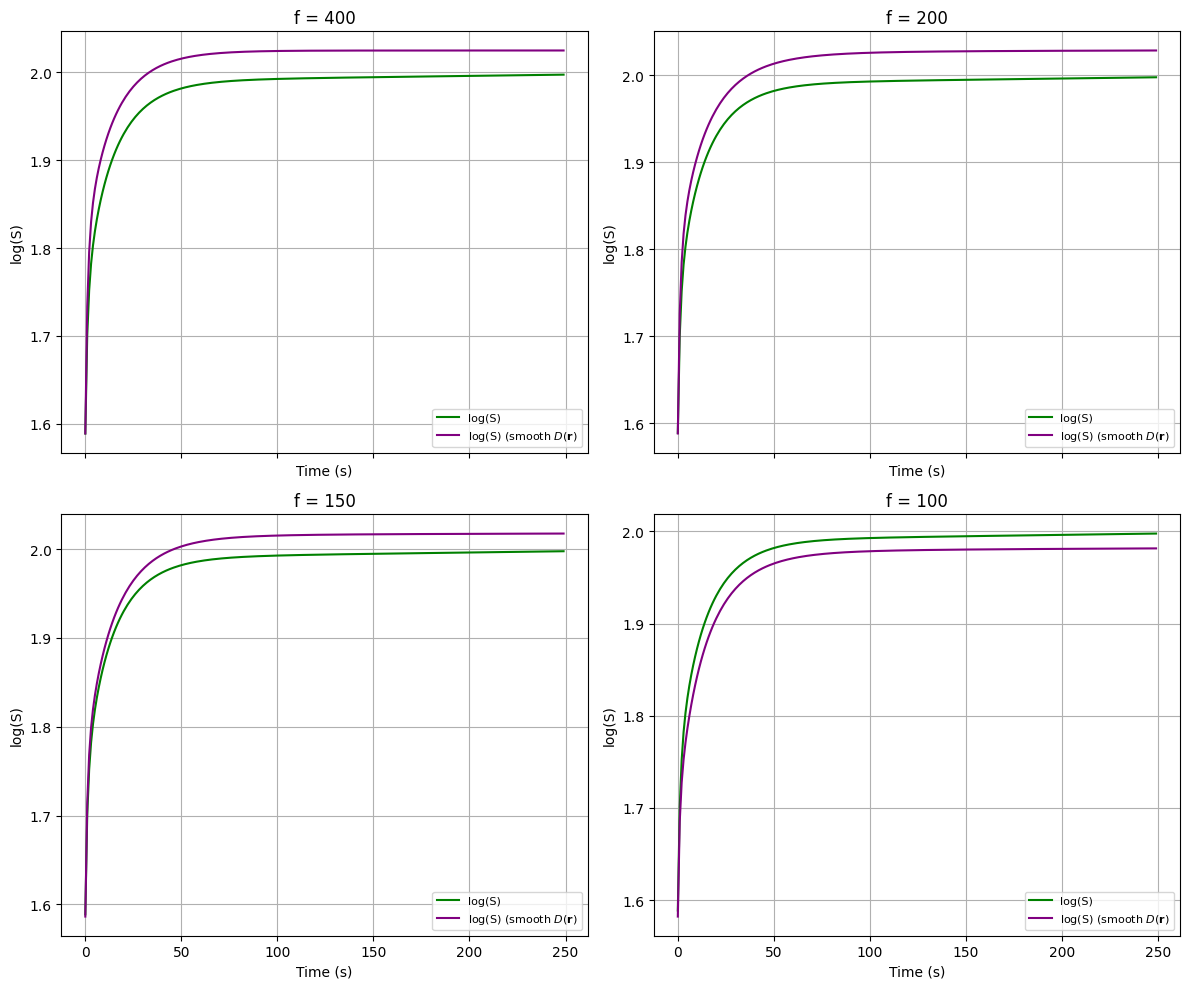

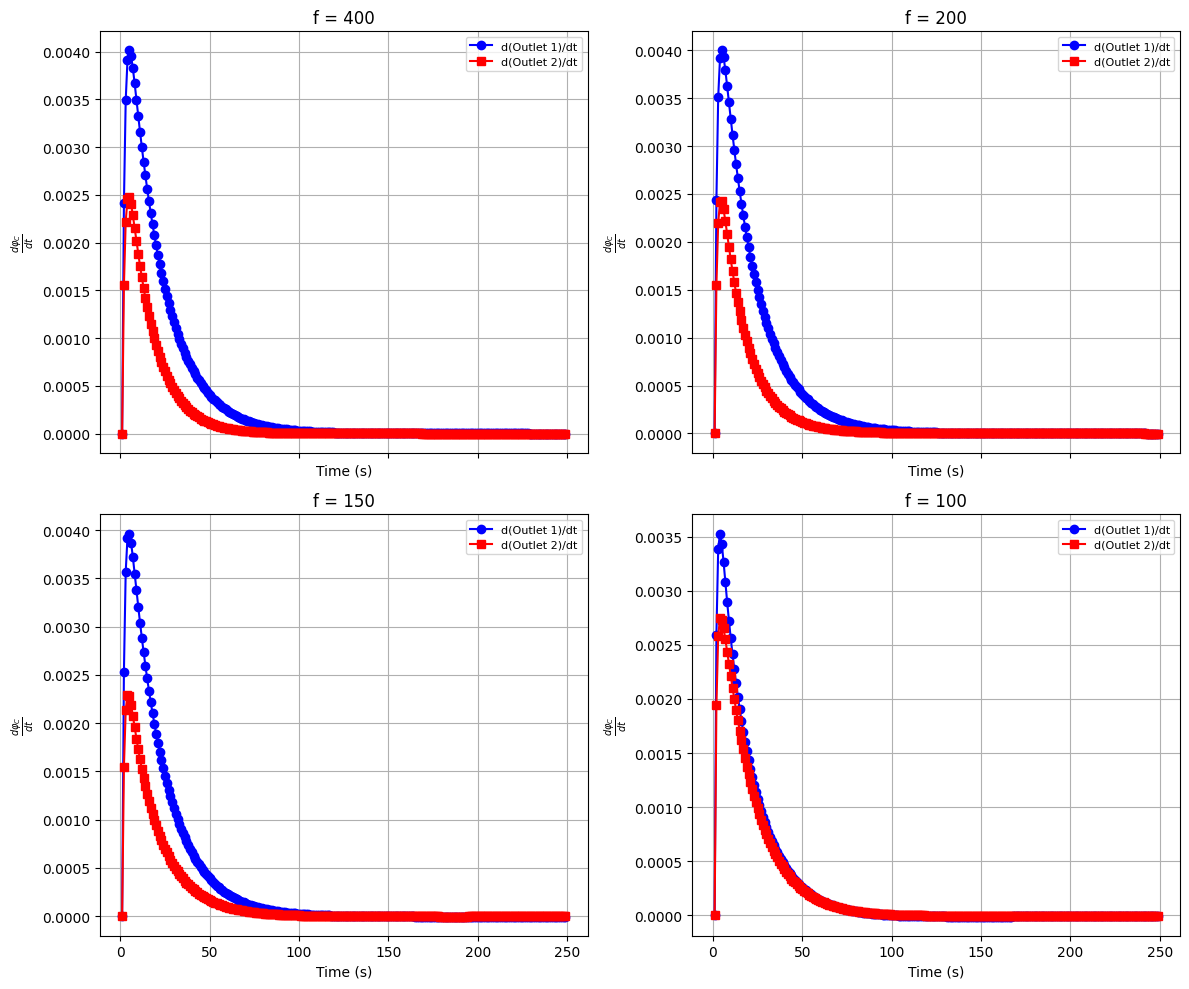

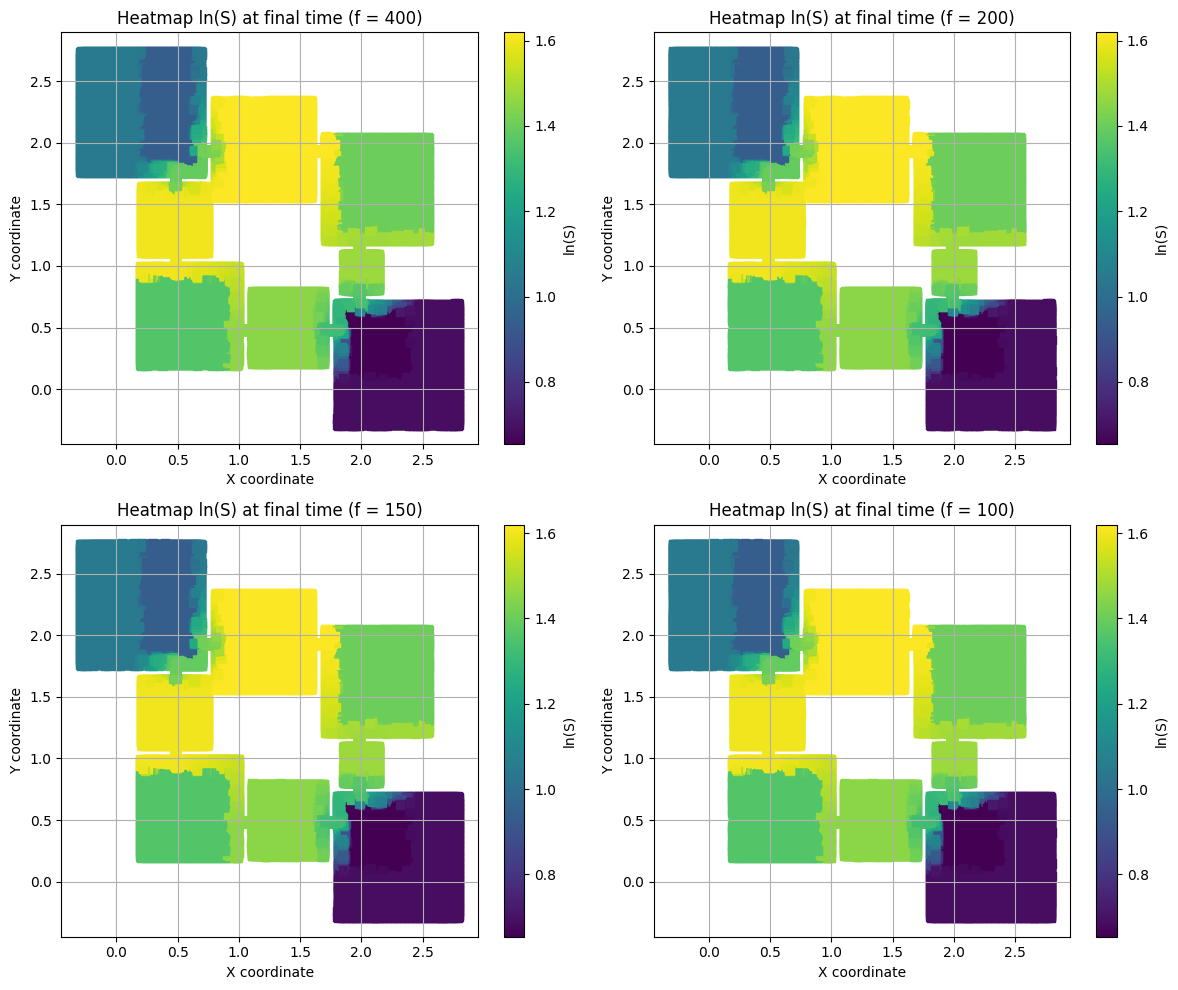

In [ ]:
# @title Plotting and Comparing runs with different f values
import numpy as np
import matplotlib.pyplot as plt

if f == 400:
    D_smooth_S_f400 = []
    C_outlet1_f400 = []
    C_outlet2_f400 = []
    C_outlet1_f400 = integral_C_outlet1_smooth_values.copy()
    C_outlet2_f400 = integral_C_outlet2_smooth_values.copy()
    D_smooth_S_f400 = integral_S_smooth_values.copy()
    print("f=400")
if f == 300:
    D_smooth_S_f300 = []
    C_outlet1_f300 = []
    C_outlet2_f300 = []
    C_outlet1_f300 = integral_C_outlet1_smooth_values.copy()
    C_outlet2_f300 = integral_C_outlet2_smooth_values.copy()
    D_smooth_S_f300 = integral_S_smooth_values.copy()
    print("f=300")
if f == 200:
    D_smooth_S_f200 = []
    C_outlet1_f200 = []
    C_outlet2_f200 = []
    C_outlet1_f200 = integral_C_outlet1_smooth_values.copy()
    C_outlet2_f200 = integral_C_outlet2_smooth_values.copy()
    D_smooth_S_f200 = integral_S_smooth_values.copy()
    print("f=200")
if f == 150:
    D_smooth_S_f150 = []
    C_outlet1_f150 = []
    C_outlet2_f150 = []
    C_outlet1_f150 = integral_C_outlet1_smooth_values.copy()
    C_outlet2_f150 = integral_C_outlet2_smooth_values.copy()
    D_smooth_S_f150 = integral_S_smooth_values.copy()
    print("f=150")
if f == 100:
    D_smooth_S_f100 = []
    C_outlet1_f100 = []
    C_outlet2_f100 = []
    C_outlet1_f100 = integral_C_outlet1_smooth_values.copy()
    C_outlet2_f100 = integral_C_outlet2_smooth_values.copy()
    D_smooth_S_f100 = integral_S_smooth_values.copy()
    print("f=100")

# =============================================
# ASSUMPTIONS:
# -------------
# You already have simulation data for each f value.
# For example, when f==400 your simulation has produced:
#   time               -- the common time array (or you can recompute it)
#   C_outlet1_f400     -- outlet 1 smooth concentration (an array)
#   C_outlet2_f400     -- outlet 2 smooth concentration (an array)
#   D_smooth_S_f400    -- smooth S data (e.g., from D_smooth_S)
#   integral_S_values_f400 -- the unsmoothed integral of S (if available)
#
# And similarly for f==300, 200, and 100.
#
# Also, for the heatmap we assume that for each run you have a FiPy mesh (or similar)
# stored in, say, fipy_mesh_f400, etc., and a corresponding field S_f400 (a FiPy variable)
# so that you can extract S_f400.value.
#
# If you do not have “f–specific” unsmoothed arrays (or heatmap data), then you can simply
# plot the smooth arrays in the subplots.
# =============================================

# -------------------------------
# Define the time array (assumed common)
# (Make sure that steps and time_step have been defined earlier.)
time = np.arange(0, steps * time_step, time_step)

# List of f values
f_values = [400, 200, 150, 100]

# Organize data by f value.
# (Replace the following dictionary entries with your actual variable names.)
data = {
    400: {
        'C1': C_outlet1_f400,       # outlet 1 (smooth)
        'C2': C_outlet2_f400,       # outlet 2 (smooth)
        'C1_sharp': integral_C_outlet1_values,
        'C2_sharp': integral_C_outlet2_values,
        'D':  D_smooth_S_f400,      # smooth S
        'S':  integral_S_values,  # unsmoothed S (if available)
        'mesh': fipy_mesh,     # mesh for heatmap
        'S_field': S         # FiPy variable for S (for heatmap)
    },
    200: {
        'C1': C_outlet1_f200,
        'C2': C_outlet2_f200,
        'C1_sharp': integral_C_outlet1_values,
        'C2_sharp': integral_C_outlet2_values,
        'D':  D_smooth_S_f200,
        'S':  integral_S_values,
        'mesh': fipy_mesh,
        'S_field': S
    },
    150: {
        'C1': C_outlet1_f150,
        'C2': C_outlet2_f150,
        'C1_sharp': integral_C_outlet1_values,
        'C2_sharp': integral_C_outlet2_values,
        'D':  D_smooth_S_f150,
        'S':  integral_S_values,
        'mesh': fipy_mesh,
        'S_field': S
    },
    100: {
        'C1': C_outlet1_f100,
        'C2': C_outlet2_f100,
        'C1_sharp': integral_C_outlet1_values,
        'C2_sharp': integral_C_outlet2_values,
        'D':  D_smooth_S_f100,
        'S':  integral_S_values,
        'mesh': fipy_mesh,
        'S_field': S
    }
}

# -------------------------------
# FIGURE 1: Outlet Concentrations over Time
# In each subplot we plot Outlet 1 and Outlet 2 (both as a line and as a scatter of every 5th point)
# and add horizontal lines for the expected outlet values.
# -------------------------------
fig1, axs1 = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
for ax, f in zip(axs1.flatten(), f_values):
    # Extract the f–specific data:
    C1 = data[f]['C1']
    C2 = data[f]['C2']
    C1_sharp = data[f]['C1_sharp']
    C2_sharp = data[f]['C2_sharp']
    # Plot the smooth data as lines:
    ax.plot(time, C1_sharp, label='Outlet 1', color='blue')
    ax.plot(time, C2_sharp, label='Outlet 2', color='red')

    # Plot markers (every 5th point):
    ax.scatter(time[::5], C1[::5], marker='x', color='blue', label='Outlet 1 (smooth $D(\mathbf{r}$)')
    ax.scatter(time[::5], C2[::5], marker='1', color='red', label='Outlet 2 (smooth $D(\mathbf{r}$')

    # Expected values (these horizontal lines appear in every subplot):
    ax.axhline(y=0.9425e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
    ax.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')

    ax.set_title(f'f = {f}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'$\varphi_C$')
    ax.grid(True)
    ax.legend(fontsize=8)

fig1.tight_layout()
fig1.savefig("C_over_time_all_f.png", dpi=300)
plt.show()


# -------------------------------
# FIGURE 2: Logarithm of S over Time
# In each subplot we compare log10 of the unsmoothed S (if available) with log10 of the smooth S.
# -------------------------------
fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
for ax, f in zip(axs2.flatten(), f_values):
    # Use the unsmoothed S and the smooth S (here, we assume data[f]['S'] exists;
    # if not, you might simply plot data[f]['D'] only).
    S_unsmooth = data[f]['S']
    S_smooth = data[f]['D']

    # Plot the logarithms:
    ax.plot(time, np.log10(S_unsmooth), label='log(S)', color='green')
    ax.plot(time, np.log10(S_smooth), label='log(S) (smooth $D(\mathbf{r})$', color='purple')

    ax.set_title(f'f = {f}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('log(S)')
    ax.grid(True)
    ax.legend(fontsize=8)

fig2.tight_layout()
fig2.savefig("IntegralLog_SmoothD_all_f.png", dpi=300)
plt.show()


# -------------------------------
# FIGURE 3: Time Derivatives of the Concentrations
# For each f, we compute the finite-difference time derivative of outlet 1 and outlet 2.
# Note that np.diff reduces the array length by one; we plot against time[1:].
# -------------------------------
fig3, axs3 = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
for ax, f in zip(axs3.flatten(), f_values):
    C1 = data[f]['C1']
    C2 = data[f]['C2']
    C1_sharp = data[f]['C1_sharp']
    C2_sharp = data[f]['C2_sharp']
    # Compute finite differences:
    dC1_dt = np.diff(C1) / time_step
    dC2_dt = np.diff(C2) / time_step

    ax.plot(time[1:], dC1_dt, label='d(Outlet 1)/dt', marker='o', color='blue')
    ax.plot(time[1:], dC2_dt, label='d(Outlet 2)/dt', marker='s', color='red')

    ax.set_title(f'f = {f}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'$\frac{d\varphi_C}{dt}$')
    ax.grid(True)
    ax.legend(fontsize=8)

fig3.tight_layout()
fig3.savefig("Concentration_Derivatives_all_f.png", dpi=300)
plt.show()


# -------------------------------
# FIGURE 4: Heatmaps of ln(S) over the Mesh at the Final Time Step
# Here we assume that each simulation has its own mesh (for example, stored as fipy_mesh_f400, etc.)
# and its corresponding field S (for example, S_f400). We compute ln(S) (taking care of S<=0)
# and then plot a scatter plot over the cell center coordinates.
# -------------------------------
fig4, axs4 = plt.subplots(2, 2, figsize=(12, 10))
for ax, f in zip(axs4.flatten(), f_values):
    mesh = data[f]['mesh']
    S_field = data[f]['S_field']

    # Get the coordinates (assuming the mesh has an attribute cellCenters as in FiPy)
    x = np.array(mesh.cellCenters[0])
    y = np.array(mesh.cellCenters[1])

    # Compute ln(S): replace non-positive values with NaN so they don’t disturb the colormap.
    ln_S = np.where(S_field.value > 0, np.log10(S_field.value), np.nan)

    sc = ax.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
    ax.set_title(f'Heatmap ln(S) at final time (f = {f})')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.grid(True)
    # Add a colorbar for each subplot. (Alternatively, you could add one global colorbar.)
    plt.colorbar(sc, ax=ax, label='ln(S)')

fig4.tight_layout()
fig4.savefig("Heatmap_lnS_all_f.png", dpi=300)
plt.show()


In [ ]:
# @title Exponential timesteps - Smooth D(x,y)
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 20:18:18 2024

@author: Giuseppe
"""
import os
# Enable FIPY_Inline flag for performance
from fipy import Gmsh2D, CellVariable, DiffusionTerm, Viewer, TransientTerm, FaceVariable, ImplicitSourceTerm
import matplotlib.pyplot as plt
import math
from fipy.tools import numerix
import numpy as np
import imageio

# Load the Gmsh mesh file directly using the file path
fipy_mesh = Gmsh2D("/content/drive/MyDrive/Colab Notebooks/2D matrix_complete_fine2.msh")  # Replace with your actual .msh file path

# Define the concentration fields for A, B, and S
A = CellVariable(name="$\varphi_A(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of A, set to 0 by default
B = CellVariable(name="$\varphi_B(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)  # Initial concentration of B
C = CellVariable(name="$\varphi_C(\mathbf{r})$", mesh=fipy_mesh, value =1e-10)
S = CellVariable(name="$s_i(\mathbf{r})$", mesh=fipy_mesh, value=1e-10)

# Lists to store the integrals of B and C over outlet1 and outlet2 at each time step
integral_B_outlet1_values = []
integral_B_outlet2_values = []
integral_C_outlet1_values = []
integral_C_outlet2_values = []


# Define the region where the concentration of A is initially 1
initial_region1 = (fipy_mesh.cellCenters[0] >= 0.1860589702) & (fipy_mesh.cellCenters[0] <= 1) & \
                  (fipy_mesh.cellCenters[1] >= 0.1860589702) & (fipy_mesh.cellCenters[1] <=1)
initial_region2 = (fipy_mesh.cellCenters[0] >= 1.7) & (fipy_mesh.cellCenters[0] <= 1.7 + 0.8544004) & \
                  (fipy_mesh.cellCenters[1] >= 1.2) & (fipy_mesh.cellCenters[1] <= 1.2 + 0.8544004)
initial_region = initial_region1 | initial_region2

# Outlets
outlet1 = (fipy_mesh.cellCenters[0] >= 0.3) & (fipy_mesh.cellCenters[0] <= 0.7) & \
          (fipy_mesh.cellCenters[1] >= 1.8) & (fipy_mesh.cellCenters[1] <= 2.15)
outlet2 = (fipy_mesh.cellCenters[0] >= 1.8) & (fipy_mesh.cellCenters[0] <= 2.2) & \
          (fipy_mesh.cellCenters[1] >= 0.3) & (fipy_mesh.cellCenters[1] <= 0.7)
outlet = outlet1 | outlet2

Inlet1=0.1
Inlet2=0.1


# Set A = 1 in the combined initial regions
A.setValue(Inlet1, where=initial_region1)
A.setValue(Inlet2, where=initial_region2)

# Define the membrane region (you can adjust the region based on the actual membrane geometry)
membrane_region1 = (fipy_mesh.cellCenters[0] >= 1.045) & (fipy_mesh.cellCenters[0] <= 1.055) & \
                  (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region2 = (fipy_mesh.cellCenters[0] >= 0.45) & (fipy_mesh.cellCenters[0] <= 0.55) & \
                   (fipy_mesh.cellCenters[1] >= 1.045) & (fipy_mesh.cellCenters[1] <= 1.055)
membrane_region3 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & \
                   (fipy_mesh.cellCenters[1] >= 1.145) & (fipy_mesh.cellCenters[1] <= 1.155)
membrane_region4 = (fipy_mesh.cellCenters[0] >= 1.645) & (fipy_mesh.cellCenters[0] <= 1.655) & \
                   (fipy_mesh.cellCenters[1] >= 1.9) & (fipy_mesh.cellCenters[1] <= 2)
membrane_region = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

# Outside the membrane region
outside_membrane_region = ~membrane_region

# Diffusion coefficients for A and B
D_A = CellVariable(mesh=fipy_mesh, value=1900.0)  # Diffusion coefficient for A \mu meters**2 /ms
D_B = CellVariable(mesh=fipy_mesh, value=1300.0)  # Diffusion coefficient for B
D_C = CellVariable(mesh=fipy_mesh, value=0.80)


# Define the reaction rate constant
k = 1
k2 = 0.000001
k_on = 0.1
k_off=1e-6
# Create the source term variable
source_term = CellVariable(mesh=fipy_mesh, value=0.0)
source_term2 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term3 = CellVariable(mesh=fipy_mesh, value=0.0)
source_term4 = CellVariable(mesh=fipy_mesh, value=0.0)

# Define the reaction zone: Complement of the initial region
reaction_zone = ~initial_region

# Apply the source term in the defined reaction zone
source_term.setValue(k, where=reaction_zone)
source_term2.setValue(k2, where=reaction_zone)
source_term3.setValue(k_on, where=outlet)
source_term4.setValue(k_off, where=outlet)
#membrane source term:


# Apply the flux condition in eq_B
# Define new membrane regions between reaction zones and outlets with width 0.1
membrane_region9 = (fipy_mesh.cellCenters[0] >= 1.745) & (fipy_mesh.cellCenters[0] <= 1.755) & (fipy_mesh.cellCenters[1] >= 0.45) & (fipy_mesh.cellCenters[1] <= 0.55)
membrane_region10 = (fipy_mesh.cellCenters[0] >= 1.95) & (fipy_mesh.cellCenters[0] <= 2.05) & (fipy_mesh.cellCenters[1] >= 0.745) & (fipy_mesh.cellCenters[1] <= 0.755)
membrane_region11 = (fipy_mesh.cellCenters[0] >= 0.475) & (fipy_mesh.cellCenters[0] <= 0.525) & (fipy_mesh.cellCenters[1] >= 1.7) & (fipy_mesh.cellCenters[1] <= 1.725)
membrane_region12 = (fipy_mesh.cellCenters[0] >= 0.745) & (fipy_mesh.cellCenters[0] <= 0.755) & (fipy_mesh.cellCenters[1] >= 1.925) & (fipy_mesh.cellCenters[1] <= 1.975)

# Combine all membrane regions, including the original one
membrane_region_outlet = membrane_region9 | membrane_region10 | membrane_region11 | membrane_region12
membrane_region_inlets = membrane_region1 | membrane_region2 | membrane_region3 | membrane_region4

D_A.setValue(0.0, where=membrane_region_outlet)  # Block A from diffusing through outlet membrane
D_B.setValue(0.0, where=membrane_region_inlets)  # Block B from diffusing through any membrane
D_C.setValue(0.0, where=membrane_region_outlet)

def center_x_membrane(membrane_region):
  mean_x = numerix.mean(fipy_mesh.cellCenters[0][membrane_region])
  return mean_x
def center_y_membrane(membrane_region):
  mean_y = numerix.mean(fipy_mesh.cellCenters[1][membrane_region])
  return mean_y
f = 500
D_C_value = 0.80*(
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - 0.1)) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region12))) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region11))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - 4)) + 1)) +
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region9))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - 2.5)) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1])) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region10))) + 1))
)
D_A_value = -(1900/0.8)*D_C_value+1900
D_B_value_helper = 1300*(
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - 0.)) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region1))) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] )) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] -center_y_membrane(membrane_region2))) + 1)) +
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[0] - center_x_membrane(membrane_region4))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[0] - 4)) + 1)) *
    (1 / (np.exp(-f * (fipy_mesh.cellCenters[1] - center_y_membrane(membrane_region3))) + 1)) *
    (1 / (np.exp(f * (fipy_mesh.cellCenters[1] - 3)) + 1))
)
D_B_value= -D_B_value_helper+1300

T = 300
R = 8.314462618
# Define the diffusion-reaction equations with directional diffusion and implicit source terms
eq_A = TransientTerm(var=A) == DiffusionTerm(coeff=D_A, var=A) - source_term * A + source_term2 * B
eq_B = TransientTerm(var=B) == DiffusionTerm(coeff=D_B, var=B) + source_term * A - source_term2 * B - source_term3 * B +source_term4*C
eq_C = TransientTerm(var=C) == DiffusionTerm(coeff=D_C, var=C) + source_term3 * B - source_term4 * C
eq = eq_A & eq_B & eq_C
grad_A = A.grad
grad_B = B.grad
grad_C = C.grad
# Compute the magnitude squared of the gradient
grad_A_squared = numerix.dot(grad_A, grad_A)
grad_B_squared = numerix.dot(grad_B, grad_B)
grad_C_squared = numerix.dot(grad_C, grad_C)
# eq_S = TransientTerm(var=S) == (1/T)*(1 + c*A/B)*D_A*(grad_A_squared) + R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
# eq_S = TransientTerm(var=S) == (1/T)*((1 + c*1/C)*D_A*(grad_A_squared) +  (1+c2*(1/C))*D_B*(grad_B_squared))+ R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))
eq_S = TransientTerm(var=S) == R*(1/T)*((1/A)*D_A*(grad_A_squared) +  (1/B)*D_B*(grad_B_squared) + (1/C)*D_C*(grad_C_squared))+ R * (np.log((k*A)/(k2*B)) * (k*A - k2*B)) +  R * (np.log((k_on*B)/(k_off*C)) * (k_on*B - k_off*C))

# Set up the viewers to visualize the concentrations of A and B
viewer_A = Viewer(vars=A, datamin=0.0, datamax=1.0e-1)
viewer_B = Viewer(vars=B, datamin=0.0, datamax=1.0e-1)
viewer_C = Viewer(vars=C, datamin=0.0, datamax=1.0e-1)
viewer_S = Viewer(vars=S, datamin=0.0, datamax=1.5e2)

# Directory to save the frames
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# Lists to store the integrals of B over outlet1 and outlet2 at each time step
integral_C_outlet1_values = []
integral_C_outlet2_values = []
# List to store the integral of S at each time step
integral_S_values = []
# List to store the time derivative of the integral of S
derivative_S_values = []

# Time-stepping parameters
start_time = 1e-4  # Smallest time step in ms
end_time = 1.0     # Largest time step in ms
total_time = 200.0 # Total simulation time in ms
num_steps = 400    # Total number of steps

# Generate geometrically spaced timesteps and normalize to fit total_time
raw_timesteps = np.geomspace(start_time, end_time, num=num_steps)
timesteps = raw_timesteps * (total_time / sum(raw_timesteps))  # Normalize timesteps
cumulative_time = np.cumsum(timesteps)  # Calculate cumulative time for plotting

# Solve the equations iteratively

for step, time_step in enumerate(timesteps):
    eq.solve(dt=time_step)  # Solve for A, B, and C
    grad_phi = A.grad
    grad_B = B.grad
    grad_phi_squared = numerix.dot(grad_phi, grad_phi)
    grad_B_squared = numerix.dot(grad_B, grad_B)
    mixed_grad = numerix.dot(grad_phi, grad_B)
    eq_S.solve(var=S, dt=time_step)  # Solve for S

    # Log every 10 steps
    if step % 10 == 0:
        print(f"Step {step}")

    # Compute the integral of B over outlet1 and outlet2 separately
    integral_C_outlet1 = numerix.sum(C.value[outlet1] * fipy_mesh.cellVolumes[outlet1])
    integral_C_outlet2 = numerix.sum(C.value[outlet2] * fipy_mesh.cellVolumes[outlet2])

    # Store the integrals for both outlets
    integral_C_outlet1_values.append(integral_C_outlet1)
    integral_C_outlet2_values.append(integral_C_outlet2)

    # Compute the integral of S over the mesh grid
    integral_S = numerix.sum(S.value * fipy_mesh.cellVolumes)
    integral_S_values.append(integral_S)  # Store the integral value

    # Plot results
   # viewer_A.plot()
   # viewer_B.plot()
   # viewer_C.plot()
    viewer_S.plot()

    # Save figure for video
    plt.savefig(f"{frame_dir}/frame_{step:03d}.png", dpi=300)

# Create video from saved frames
with imageio.get_writer('simulation_gradS_expnormalized.mp4', fps=48) as video_writer:
    for step in range(num_steps):
        filename = f"{frame_dir}/frame_{step:03d}.png"
        video_writer.append_data(imageio.imread(filename))

# Clean up by removing saved frames
for step in range(num_steps):
    os.remove(f"{frame_dir}/frame_{step:03d}.png")

# Plot the integral of B over outlet1 and outlet2 over cumulative time
plt.figure()
plt.plot(cumulative_time, integral_C_outlet1_values, label='Outlet 1')
plt.plot(cumulative_time, integral_C_outlet2_values, label='Outlet 2')
plt.axhline(y=0.7925e-1, color="b", linestyle="dashdot", label='Expected Outlet 1')
plt.axhline(y=0.45e-1, color="r", linestyle="dashdot", label='Expected Outlet 2')
plt.xlabel('Time (ms)')
plt.ylabel('Integral of B')
plt.title('Integral of C in Outlet 1 and Outlet 2 over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.legend()
plt.savefig("C_over_time_ExponentialNormalized_outlets.png", dpi=300)
plt.show()

# Plot the integral of S over cumulative time
plt.figure()
plt.plot(cumulative_time, np.log10(integral_S_values))
plt.xlabel('Time (ms)')
plt.ylabel('Integral of log(S)')
plt.title('Integral of log(S) over time (Normalized Exponential Timesteps)')
plt.grid(True)
plt.savefig("IntegralLN-S_ExponentialNormalized.png", dpi=300)
plt.show()


# Compute and plot heatmap of ln(S) over the mesh at the last time step
ln_S = np.log10(S.value)  # Compute ln(S), handle potential issues with S <= 0 by avoiding these values
ln_S = np.where(S.value > 0, np.log10(S.value), np.nan)  # Replace negative or zero values with NaN for safe plotting

# Generate heatmap of ln(S) using the mesh coordinates
x = np.array(fipy_mesh.cellCenters[0])  # X coordinates of the mesh cells
y = np.array(fipy_mesh.cellCenters[1])  # Y coordinates of the mesh cells

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=ln_S, cmap='viridis', marker='s')
plt.colorbar(label='ln(S)')
plt.title('Heatmap of ln(S) over the mesh at final time step')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.savefig("Heatmap_lnS.png", dpi=300)
plt.show()
